# Forecasting Iran Inflation Rates 

Author: **Saber Kazemi**<br>
Date: November, 2024



# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from persiantools.jdatetime import JalaliDate
import yfinance as yf
import warnings
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from scipy.stats import boxcox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.model_selection import TimeSeriesSplit
import itertools
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

# Additional settings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=ValueWarning)

# Data Loading and Preprocessing 
<ol>
  <li>
    <strong>Loading the Dataset</strong>:<br>
    The dataset is loaded from an Excel file (<code>inflation.xlsx</code>) containing historical inflation data.
  </li>
  <li>
    <strong>Creating a Persian Date Column</strong>:<br>
    The dataset includes separate <code>year</code> and <code>month</code> columns. These are combined into a new column named <code>'Persian Date'</code> using string concatenation (<code>year/month</code>).
  </li>
  <li>
    <strong>Converting Persian Date to Gregorian Date</strong>:<br>
    A function <code>persian_to_gregorian(year, month)</code> is defined to convert the Persian date to a Gregorian date using the <code>JalaliDate</code> library. The conversion function is applied to each row to create a new column named <code>'Date'</code> with the corresponding Gregorian dates.
  </li>
  <li>
    <strong>Setting Date as Index</strong>:<br>
    The <code>'Date'</code> column is converted to datetime format and set as the index of the DataFrame. The index is then normalized to the first day of each month to ensure consistency.
  </li>
  <li>
    <strong>Dropping Unnecessary Columns</strong>:<br>
    The original <code>year</code> and <code>month</code> columns are dropped since the <code>'Date'</code> index now captures the temporal information.
  </li>
  <li>
\    
  </li>
  <li>
    <strong>Handling Missing Values</strong>:<br>
    Any missing values that might have resulted from operations (e.g., differencing) are removed from the DataFrame.
  </li>
</ol>


In [2]:
df = pd.read_excel('inflation.xlsx')

# Combine 'year' and 'month' to create the Persian date
df['Persian Date'] = df['year'].astype(str) + '/' + df['month'].astype(str)

# Convert Persian date to Gregorian date
def persian_to_gregorian(year, month):
    j_date = JalaliDate(year, month, 1)
    g_date = j_date.to_gregorian()
    return g_date.strftime('%Y-%m-%d')

# Apply conversion to each row to get Gregorian date
df['Date'] = pd.to_datetime(df.apply(lambda row: persian_to_gregorian(row['year'], row['month']), axis=1))

# Set 'Date' as the DataFrame index, normalized to the first day of each month
df.set_index('Date', inplace=True)
df.index = df.index.normalize()

# Drop unnecessary columns
df.drop(columns=['year', 'month'], inplace=True)

# Remove NaN values resulting from differencing
df.dropna(inplace=True)

# EDA

### Complete EDA Function for Time Series Data


In [3]:
def complete_time_series_eda(df, rate_column='CPI', rolling_window=12):
    
 
    series = df[rate_column]
    sns.set(style="whitegrid")

    # Convert index to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    # Plot 1: Original Series with Rolling Statistics
    plt.figure(figsize=(14, 6))
    mean_rolling = series.rolling(window=rolling_window).mean()
    std_rolling = series.rolling(window=rolling_window).std()
    
    plt.plot(series, label='Original', color='blue', linewidth=2)
    plt.plot(mean_rolling, color='crimson', linestyle='--', label='Rolling Mean')
    plt.plot(std_rolling, color='black', linestyle=':', label='Rolling Std')
    plt.title('Time Series with Rolling Mean & Standard Deviation', fontsize=16, weight='bold')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Plot 2: Seasonal Decomposition
    decomp = seasonal_decompose(series, model='additive', period=rolling_window)
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(14, 10))
    fig.suptitle('Seasonal Decomposition', fontsize=16, weight='bold')
    
    decomp.trend.plot(ax=axes[0], legend=False, color='blue')
    axes[0].set_ylabel('Trend', fontsize=12)
    
    decomp.seasonal.plot(ax=axes[1], legend=False, color='green')
    axes[1].set_ylabel('Seasonal', fontsize=12)
    
    decomp.resid.plot(ax=axes[2], legend=False, color='red')
    axes[2].set_ylabel('Residual', fontsize=12)
    
    decomp.observed.plot(ax=axes[3], legend=False, color='black')
    axes[3].set_ylabel('Original', fontsize=12)
    plt.xlabel('Date', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot 3: Distribution of the Series
    plt.figure(figsize=(12, 6))
    sns.histplot(series, bins=50, color='skyblue', edgecolor='black', kde=True, alpha=0.7)
    plt.title('Distribution of Time Series Values', fontsize=16, weight='bold')
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 4: Autocorrelation and Partial Autocorrelation
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    plot_acf(series.dropna(), lags=40, ax=axes[0], color='blue')
    plot_pacf(series.dropna(), lags=40, ax=axes[1], color='red')
    axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14)
    axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot 5: Lag Plot to Check for Autocorrelation
    from pandas.plotting import lag_plot
    plt.figure(figsize=(8, 6))
    lag_plot(series)
    plt.title('Lag Plot of Time Series', fontsize=16, weight='bold')
    plt.xlabel('Lag 1', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Stationarity Test: Augmented Dickey-Fuller Test
    from statsmodels.tsa.stattools import adfuller
    
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: {:.6f}'.format(result[0]))
    print('2. P-value: {:.6f}'.format(result[1]))
    print('3. Used Lags: {}'.format(result[2]))
    print('4. Used Observations: {}'.format(result[3]))
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.6f}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

   


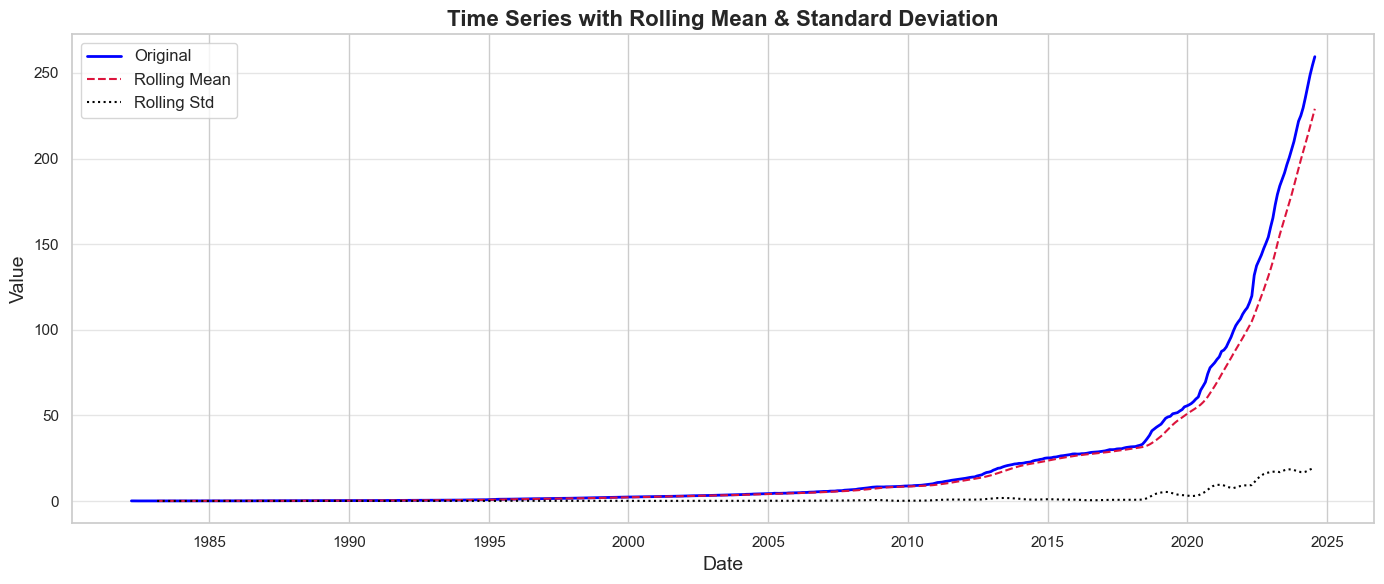

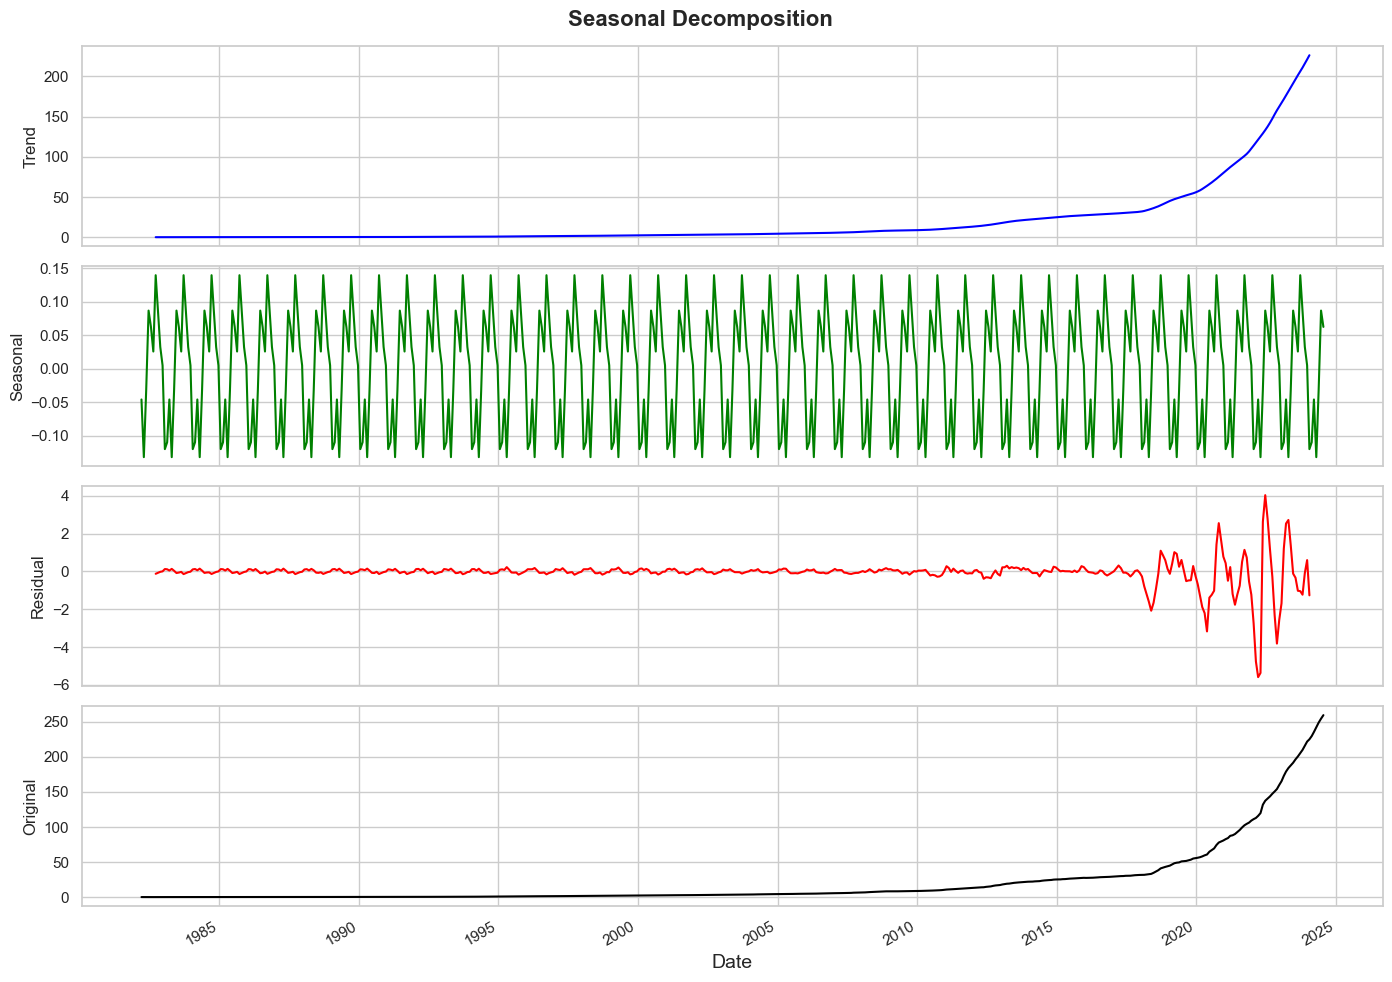

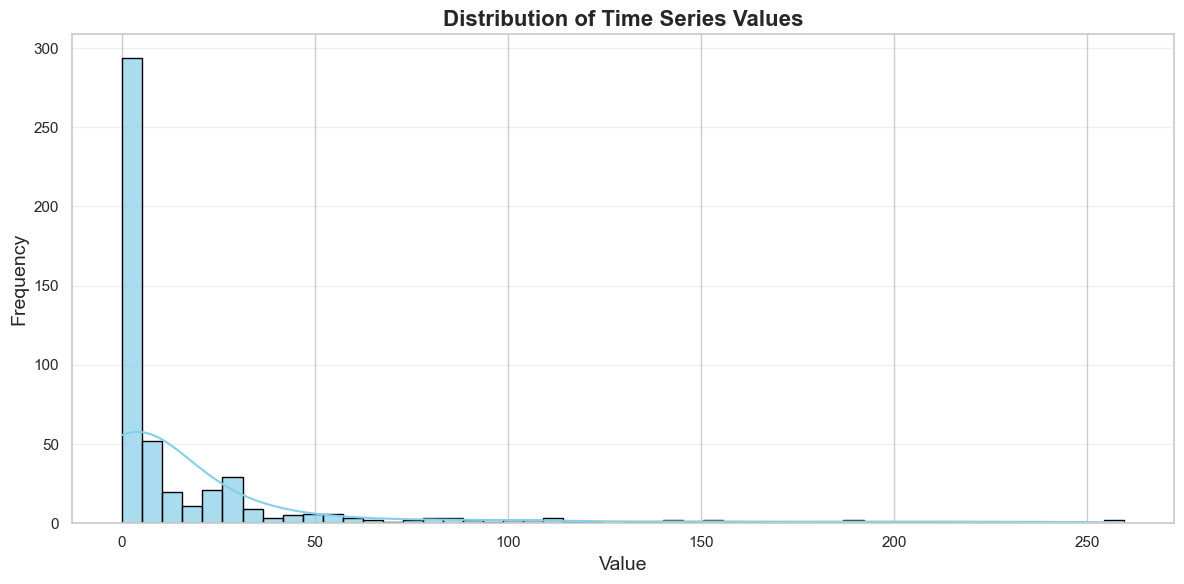

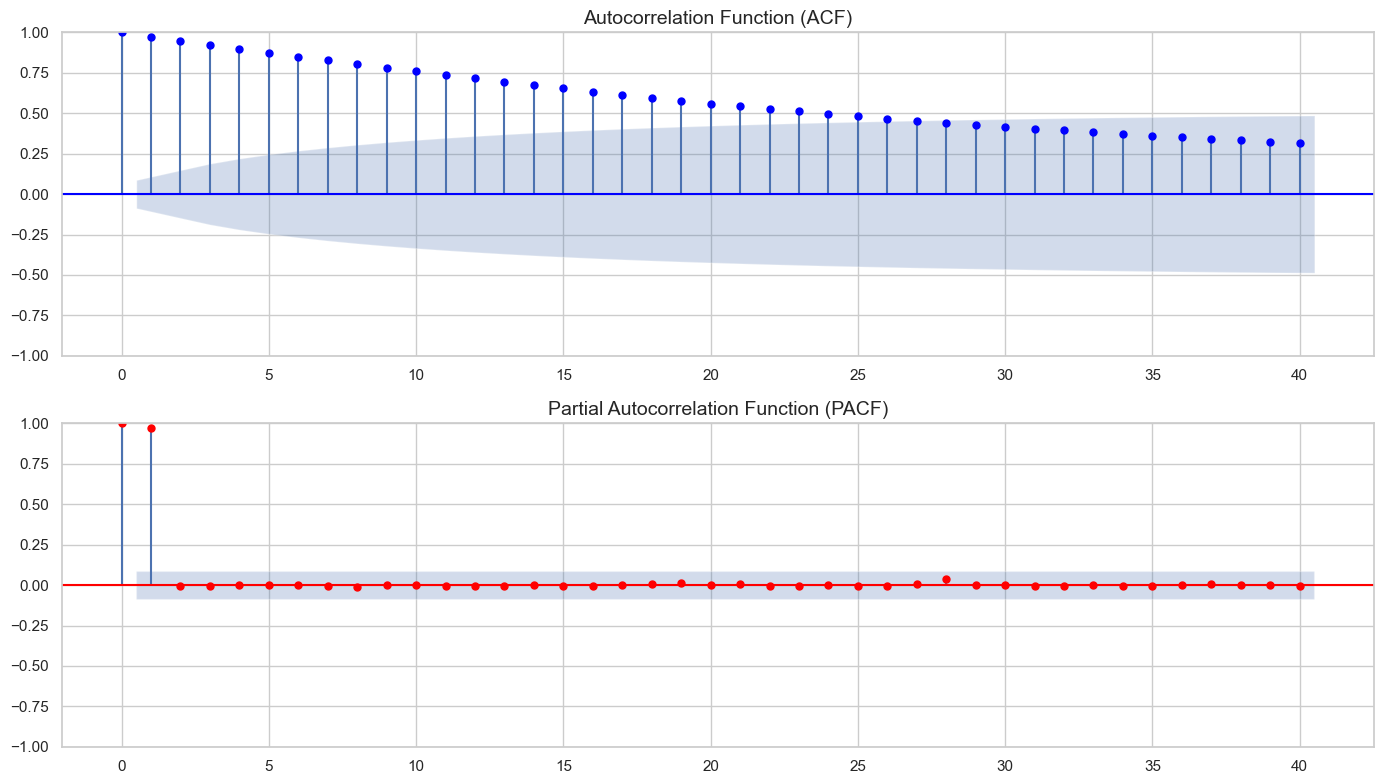

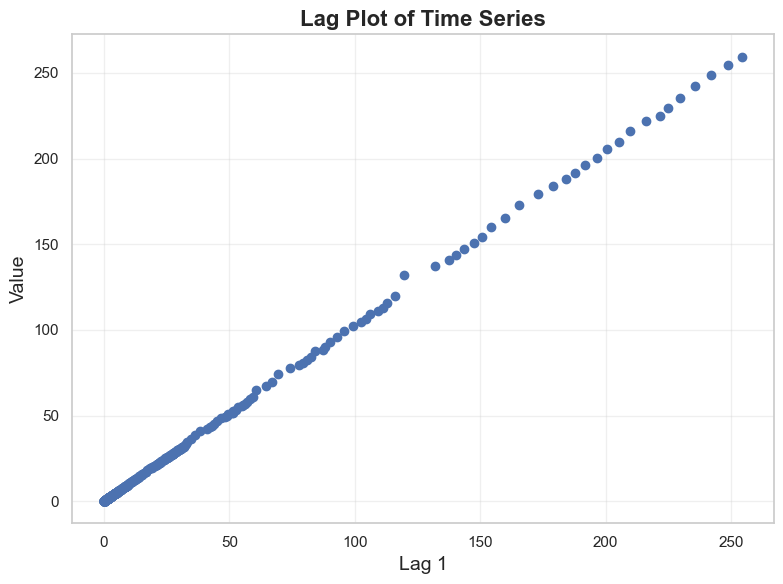

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic: 3.674590
2. P-value: 1.000000
3. Used Lags: 19
4. Used Observations: 489
5. Critical Values:
	1%: -3.443794
	5%: -2.867469
	10%: -2.569928

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


In [4]:
complete_time_series_eda(df, rate_column='CPI', rolling_window=12)


Seasonal Decomposition<br>
This graph represents a Seasonal Decomposition of the time series data. This type of decomposition is typically done to break down the time series into several components to better understand the underlying patte

1. Trend Component (Top Panel - Blue Line):
- The trend component represents the long-term progression or direction in the time series data.
- In this graph, the trend starts very low and remains flat until approximately 2010, after which there is a noticeable upward trend, accelerating steeply from around 2020. This indicates a rapid increase in the overall value of the time series, which could be reflective of exponential growth in whatever phenomenon this data represents.
2. Seasonal Component (Second Panel - Green Line):<br>
- The seasonal component captures the recurring patterns or cycles that repeat at regular intervals (e.g., monthly, yearly).
- Here, we see a well-defined periodic pattern with regular peaks and troughs, which suggests that there is a repeating seasonal effect in the data.
- The seasonal fluctuations appear stable throughout the entire timeline, indicating that these seasonal changes are consistent over time.
3. Residual Component (Third Panel - Red Line):<br>
- The residual component represents the random noise or irregular variations in the time series after accounting for trend and seasonal components.
- From the graph, the residual values are relatively stable and close to zero for most of the time, but starting from around 2015, there is an increase in the residual variation, particularly in the form of spikes.
- These increased residual values suggest that the data is becoming more unpredictable or noisy in recent years, indicating that there may be additional factors influencing the data that are not captured by the trend or seasonal components.
4. Original Component (Bottom Panel - Black Line):<br>
- This panel shows the original time series data.
- Similar to the trend component, we can observe that the data remains fairly steady until around 2010-2015, after which there is a very steep rise. The pattern indicates exponential-like growth in recent years, which aligns with the trend component.


Lag Plot<br>
- The points in the lag plot form a distinct and strong linear pattern along a diagonal line, suggesting a strong positive correlation between each observation and its immediate preceding value.
- This means that the time series is highly autocorrelated, which indicates that the current values are heavily dependent on the previous values. In other words, the series is persistent, which is common in trending time series data.

# Preprocesing

## Handle outliers and High volatility

In [5]:
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer


def choose_data_transformation(data, transformation_type="log", visualize=False):
    """
    Applies different types of transformations to the input data.

    Parameters:
        data (pd.Series or np.array): The input time series data.
        transformation_type (str): The type of transformation to apply. Options include:
                                  - 'log': Log Transformation
                                  - 'boxcox': Box-Cox Transformation
                                  - 'yeo_johnson': Yeo-Johnson Power Transformation
                                  - 'sqrt': Square Root Transformation
        visualize (bool): If True, plots the original and transformed data for comparison.

    Returns:
        transformed_data (np.array): The transformed data.
    """
    # Ensure data is a NumPy array for easier transformation
    data = np.array(data)

    if transformation_type == "log":
        # Log Transformation (adding a small constant to avoid log(0))
        transformed_data = np.log(data + 1e-9)

    elif transformation_type == "boxcox":
        # Box-Cox Transformation (only works for positive data)
        if np.any(data <= 0):
            raise ValueError("Box-Cox transformation requires all data to be positive.")
        transformed_data, _ = boxcox(data)

    elif transformation_type == "yeo_johnson":
        # Yeo-Johnson Power Transformation (can handle positive and negative values)
        transformer = PowerTransformer(method='yeo-johnson')
        transformed_data = transformer.fit_transform(data.reshape(-1, 1)).flatten()

    elif transformation_type == "sqrt":
        # Square Root Transformation (adding a small constant to avoid sqrt(0))
        transformed_data = np.sqrt(data + 1e-9)
    elif transformation_type == "minmax":
        # Min-Max Scaling
        scaler = MinMaxScaler()
        transformed_data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    else:
        raise ValueError("Unsupported transformation type. Choose among 'log', 'boxcox', 'yeo_johnson', 'sqrt'.")

    # Visualize the original and transformed data
    if visualize:
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(data, label='Original Data', color='blue')
        plt.title('Original Data')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(transformed_data, label=f'Transformed Data ({transformation_type})', color='red')
        plt.title(f'{transformation_type.title()} Transformation')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return transformed_data



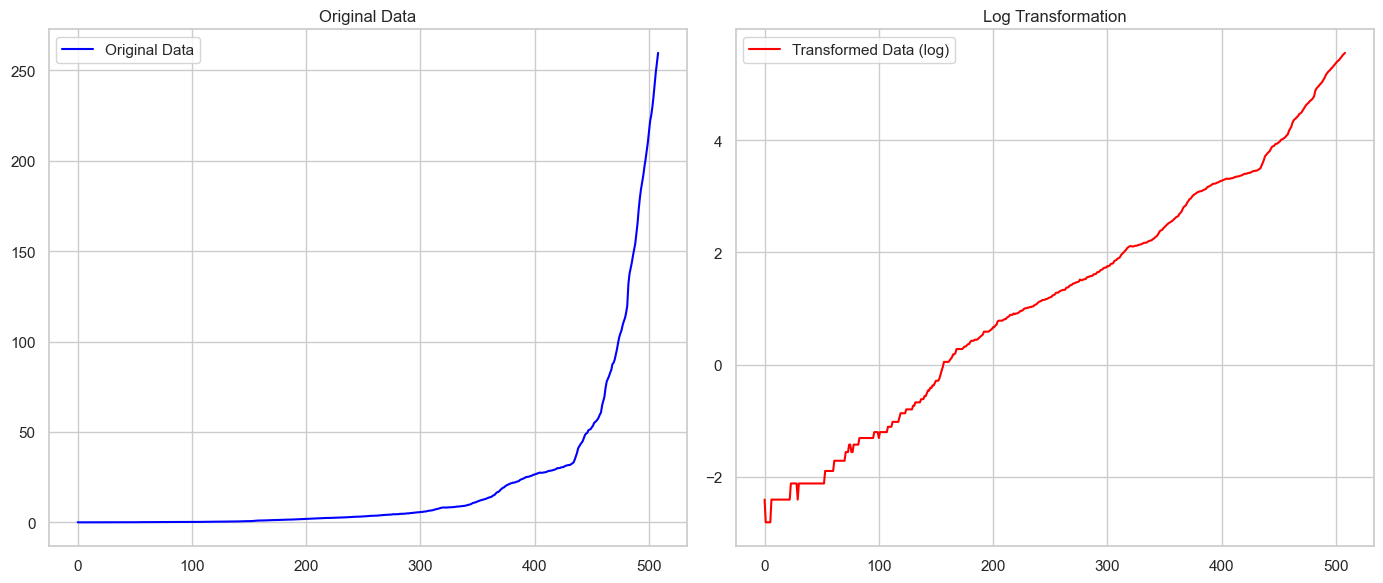

In [6]:
df['CPI'] = choose_data_transformation(df['CPI'], transformation_type='log', visualize=True)

The Consumer Price Index (CPI) column is transformed using the natural logarithm (<code>np.log(df['CPI'])</code>). This transformation is useful for stabilizing the variance in time series data and making it more suitable for modeling.

# Data Splitting

Split the data into training and testing sets


In [7]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Model Building and Selection

Grid search to find the best ARIMA model order


In [8]:
best_aic = np.inf
best_order = None
best_arima_model = None

p = d = q = range(0, 6)
combinations = list(itertools.product(p, d, q))

for order in combinations:
    try:
        model = ARIMA(train['CPI'], order=order)
        result = model.fit()
        aic = result.aic
        mse = mean_squared_error(train['CPI'], result.fittedvalues)
        mae = mean_absolute_error(train['CPI'], result.fittedvalues)
        r2 = r2_score(train['CPI'], result.fittedvalues)
        print(f"Order: {order}, AIC: {aic:.2f}, MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_arima_model = result
    except Exception as e:
        print(f"Order: {order} failed due to {str(e)}")
        continue

print(f"\nBest ARIMA Order: {best_order} with AIC: {best_aic}\n")

# Make predictions using the best ARIMA model
arima_forecast = best_arima_model.forecast(steps=len(test))

Order: (0, 0, 0), AIC: 1614.78, MSE: 3.06, MAE: 1.52, R2: -0.00
Order: (0, 0, 1), AIC: 1066.39, MSE: 0.81, MAE: 0.77, R2: 0.73
Order: (0, 0, 2), AIC: 600.55, MSE: 0.27, MAE: 0.42, R2: 0.91
Order: (0, 0, 3), AIC: 216.27, MSE: 0.12, MAE: 0.26, R2: 0.96
Order: (0, 0, 4), AIC: -56.27, MSE: 0.07, MAE: 0.18, R2: 0.98
Order: (0, 0, 5), AIC: -262.87, MSE: 0.05, MAE: 0.14, R2: 0.98
Order: (0, 1, 0), AIC: -1306.10, MSE: 0.02, MAE: 0.02, R2: 0.99
Order: (0, 1, 1), AIC: -1304.27, MSE: 0.02, MAE: 0.03, R2: 0.99
Order: (0, 1, 2), AIC: -1303.07, MSE: 0.02, MAE: 0.03, R2: 0.99
Order: (0, 1, 3), AIC: -1308.69, MSE: 0.02, MAE: 0.03, R2: 0.99
Order: (0, 1, 4), AIC: -1307.01, MSE: 0.02, MAE: 0.03, R2: 0.99
Order: (0, 1, 5), AIC: -1314.89, MSE: 0.02, MAE: 0.03, R2: 0.99
Order: (0, 2, 0), AIC: -1049.34, MSE: 0.02, MAE: 0.03, R2: 0.99
Order: (0, 2, 1), AIC: -1328.38, MSE: 0.02, MAE: 0.03, R2: 0.99
Order: (0, 2, 2), AIC: -1335.16, MSE: 0.02, MAE: 0.03, R2: 0.99
Order: (0, 2, 3), AIC: -1335.49, MSE: 0.02, MAE:

In [9]:
import pmdarima as pm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")



# Seasonal ARIMA (SARIMA) model
# auto_arima automatically finds the best (p, d, q) and (P, D, Q, m) where 'm' is the seasonal period
best_sarima_model = auto_arima(train['CPI'],
                        start_p=0, max_p=9,
                        start_q=0, max_q=9,
                        d=None,            # Automatically detect the differencing order
                        seasonal=True,     # Enable seasonal components
                        start_P=0, max_P=3,
                        start_Q=0, max_Q=3,
                        D=None,            # Automatically detect the seasonal differencing order
                        m=12,              # Set the seasonal period, e.g., monthly seasonality
                        trace=True,        # Enable verbose output
                        error_action='ignore',  # Silently ignore errors
                        suppress_warnings=True, # Suppress warnings for better readability
                        stepwise=True)     # Stepwise approach to reduce search time


best_sarima_order = best_sarima_model.order
best_sarima_seasonal_order = best_sarima_model.seasonal_order
# Step 2: Make predictions using the selected model
sarima_forecast = best_sarima_model.predict(n_periods=len(test))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1340.186, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1344.737, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1346.292, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1306.098, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-1347.381, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-1346.483, Time=0.32 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-1349.917, Time=0.95 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=-1346.559, Time=3.05 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=-1346.257, Time=2.57 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=-1346.491, Time=0.70 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=-1347.507, Time=1.67 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=3.20 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-1341.375, Time=0.65 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-1351.163, Time=0.95 sec
 ARIMA(1,1,

In [10]:
import re
import statsmodels.api as sm



def extract_summary_items(model):
    """
    Extracts key summary items from a fitted SARIMA/ARIMA model.

    Parameters:
        model: A fitted SARIMA/ARIMA model object.

    Returns:
        dict: A dictionary containing extracted summary elements.
    """
    summary_dict = {}
    
    # Extract AIC and BIC
    summary_dict['AIC'] = model.aic
    summary_dict['BIC'] = model.bic
    
    # Extract coefficients information
    params = model.params
    pvalues = model.pvalues
    bse = model.bse
    coefficients = []
    for coef_name, coef_value, std_err, p_value in zip(params.index, params.values, bse.values, pvalues.values):
        coefficients.append((coef_name, coef_value, std_err, p_value))
    summary_dict['coefficients'] = coefficients
    
    # Extract Ljung-Box test results (using the residuals)
    ljung_box_test = sm.stats.acorr_ljungbox(model.resid, lags=[10], return_df=True).iloc[0]
    summary_dict['ljung-box'] = {
        'test_statistic': ljung_box_test['lb_stat'],
        'p_value': ljung_box_test['lb_pvalue']
    }

    # Extract Jarque-Bera test results for normality
    jarque_bera_test = sm.stats.jarque_bera(model.resid)
    summary_dict['jarque-bera'] = {
        'test_statistic': jarque_bera_test[0],
        'p_value': jarque_bera_test[1]
    }

    # Extract Heteroskedasticity test results if exogenous variables are available
    if model.model.exog is not None:
        exog = model.model.exog
        if exog.shape[1] == 1:  # If there's only one column, add a constant
            exog = sm.add_constant(exog, has_constant='add')
        het_test = sm.stats.het_breuschpagan(model.resid, exog)
        summary_dict['heteroskedasticity'] = {
            'test_statistic': het_test[0],
            'p_value': het_test[1]
        }
    
    return summary_dict

def interpret_summary_items(summary_items):
    """
    Interprets the items from the summary output of a SARIMAX/ARIMA model.

    Parameters:
        summary_items (dict): A dictionary containing the summary elements to be interpreted.
                              Keys should be items from the summary (e.g., 'AIC', 'BIC', 'coefficients').

    Returns:
        str: An interpreted explanation for each item, including analysis and critical assessment.
    """

    interpretation = []

    for key, value in summary_items.items():
        key = key.lower()  # Convert key to lowercase for easier matching
        
        if key == "aic":
            interpretation.append("**AIC (Akaike Information Criterion):**")
            interpretation.append(f"AIC Value: {value:.2f}")
            interpretation.append("- The AIC value helps in model selection, balancing the model's goodness of fit with its complexity.")
            interpretation.append("- Lower AIC values are preferred as they indicate a better trade-off between accuracy and complexity.")
            if value > 800:
                interpretation.append("- Critical Analysis: The AIC value is relatively high, suggesting that the model may be too complex or not fit well. Consider simplifying the model.\n")
            else:
                interpretation.append("- Critical Analysis: The AIC value is reasonable, indicating an appropriate balance between fit and complexity.\n")
        
        elif key == "bic":
            interpretation.append("**BIC (Bayesian Information Criterion):**")
            interpretation.append(f"BIC Value: {value:.2f}")
            interpretation.append("- The BIC penalizes model complexity more heavily than AIC, favoring simpler models.")
            interpretation.append("- Similar to AIC, lower BIC values suggest a better model.")
            if value > 850:
                interpretation.append("- Critical Analysis: The BIC value is high, indicating the model might be overfitting or overly complex.\n")
            else:
                interpretation.append("- Critical Analysis: The BIC value indicates an acceptable level of complexity.\n")

        elif key == "coefficients":
            interpretation.append("**Model Coefficients and Their Significance:**")
            interpretation.append("The coefficients describe how past values (AR) or past errors (MA) affect future values.")
            interpretation.append("Below is the analysis of the coefficient table:\n")
            for coef in value:
                coef_name, coef_value, std_err, p_value = coef
                interpretation.append(f"- **{coef_name}:** Coefficient value is {coef_value:.2f}, with a standard error of {std_err:.2f}.")
                if p_value < 0.05:
                    interpretation.append(f"  - p-value ({p_value:.3f}) indicates this coefficient is statistically significant.")
                else:
                    interpretation.append(f"  - p-value ({p_value:.3f}) suggests this coefficient is not statistically significant, consider removing it for simplicity.")
            interpretation.append("")

        elif key == "ljung-box":
            interpretation.append("**Ljung-Box Test (Residual Independence):**")
            interpretation.append(f"Ljung-Box Test Statistic: {value['test_statistic']:.2f}, p-value: {value['p_value']:.3f}")
            if value['p_value'] > 0.05:
                interpretation.append("- The p-value is greater than 0.05, indicating that the residuals are likely independent, which suggests a good model fit.")
            else:
                interpretation.append("- Critical Analysis: The p-value is below 0.05, indicating residual autocorrelation, which means the model may need improvement.\n")

        elif key == "jarque-bera":
            interpretation.append("**Jarque-Bera Test (Normality of Residuals):**")
            interpretation.append(f"Jarque-Bera Test Statistic: {value['test_statistic']:.2f}, p-value: {value['p_value']:.3f}")
            if value['p_value'] > 0.05:
                interpretation.append("- The p-value is greater than 0.05, suggesting that the residuals are normally distributed.")
            else:
                interpretation.append("- Critical Analysis: The p-value is less than 0.05, indicating that the residuals deviate from normality, which could affect prediction accuracy.\n")

        elif key == "heteroskedasticity":
            interpretation.append("**Heteroskedasticity Test (Constant Variance of Residuals):**")
            interpretation.append(f"Heteroskedasticity Test Statistic: {value['test_statistic']:.2f}, p-value: {value['p_value']:.3f}")
            if value['p_value'] > 0.05:
                interpretation.append("- The p-value indicates homoscedasticity, meaning the residuals have constant variance, which is a good sign.")
            else:
                interpretation.append("- Critical Analysis: Residuals show signs of heteroskedasticity, indicating the variance may not be constant and suggesting potential outliers or model deficiencies.\n")

        else:
            interpretation.append(f"**{key.title()}:**")
            interpretation.append(f"Value: {value}")
            interpretation.append("- Note: No specific interpretation logic available for this key.\n")

    return "\n".join(interpretation)

In [11]:
best_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  407
Model:                 ARIMA(5, 2, 1)   Log Likelihood                 684.101
Date:                Sat, 16 Nov 2024   AIC                          -1354.201
Time:                        20:29:04   BIC                          -1326.174
Sample:                             0   HQIC                         -1343.107
                                - 407                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1883      0.024     -7.845      0.000      -0.235      -0.141
ar.L2         -0.1114      0.041     -2.727      0.006      -0.191      -0.031
ar.L3         -0.0674      0.044     -1.532      0.125      -0.154       0.019
ar.L4         -0.0931      0.045     -2.081      0.037      -0.181      -0.005
ar.L5         -0.2804      0.020    -13.958      0.000      -0.320      -0.241
ma.L1         -0.9841      0.024    -40.799      0.000      -1.031      -0.937
sigma2         0.0020   6.46e-05     30.353      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   4.50   Jarque-Bera (JB):              9524.50
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             2.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
best_arima_model = extract_summary_items(best_arima_model)
interpretation = interpret_summary_items(best_arima_model)
print(interpretation)

**AIC (Akaike Information Criterion):**
AIC Value: -1354.20
- The AIC value helps in model selection, balancing the model's goodness of fit with its complexity.
- Lower AIC values are preferred as they indicate a better trade-off between accuracy and complexity.
- Critical Analysis: The AIC value is reasonable, indicating an appropriate balance between fit and complexity.

**BIC (Bayesian Information Criterion):**
BIC Value: -1326.17
- The BIC penalizes model complexity more heavily than AIC, favoring simpler models.
- Similar to AIC, lower BIC values suggest a better model.
- Critical Analysis: The BIC value indicates an acceptable level of complexity.

**Model Coefficients and Their Significance:**
The coefficients describe how past values (AR) or past errors (MA) affect future values.
Below is the analysis of the coefficient table:

- **ar.L1:** Coefficient value is -0.19, with a standard error of 0.02.
  - p-value (0.000) indicates this coefficient is statistically significant.
- *

In [13]:
best_sarima_model = SARIMAX(
    train['CPI'],  # Use the full dataset for the final model
    order=best_sarima_order,  # Best ARIMA order from previous step
    seasonal_order=best_sarima_seasonal_order,  # Best seasonal order
    # enforce_stationarity=False,
    # enforce_invertibility=False
)


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the model
best_sarima_model = SARIMAX(
    train['CPI'],  # Use the full dataset for the final model
    order=best_sarima_order,  # Best ARIMA order from previous step
    seasonal_order=best_sarima_seasonal_order,  # Best seasonal order
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
best_sarima_results = best_sarima_model.fit()

# Get the summary
print(best_sarima_results.summary())


                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  407
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 716.968
Date:                Sat, 16 Nov 2024   AIC                          -1423.936
Time:                        20:29:04   BIC                          -1403.941
Sample:                             0   HQIC                         -1416.020
                                - 407                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1309      0.034     32.890      0.000       1.063       1.198
ar.L2         -0.1319      0.034     -3.831      0.000      -0.199      -0.064
ma.L1         -1.3397     11.200     -0.120      0.9

In [15]:
summary_items = extract_summary_items(best_sarima_results)
interpretation = interpret_summary_items(summary_items)
print(interpretation)

**AIC (Akaike Information Criterion):**
AIC Value: -1423.94
- The AIC value helps in model selection, balancing the model's goodness of fit with its complexity.
- Lower AIC values are preferred as they indicate a better trade-off between accuracy and complexity.
- Critical Analysis: The AIC value is reasonable, indicating an appropriate balance between fit and complexity.

**BIC (Bayesian Information Criterion):**
BIC Value: -1403.94
- The BIC penalizes model complexity more heavily than AIC, favoring simpler models.
- Similar to AIC, lower BIC values suggest a better model.
- Critical Analysis: The BIC value indicates an acceptable level of complexity.

**Model Coefficients and Their Significance:**
The coefficients describe how past values (AR) or past errors (MA) affect future values.
Below is the analysis of the coefficient table:

- **ar.L1:** Coefficient value is 1.13, with a standard error of 0.03.
  - p-value (0.000) indicates this coefficient is statistically significant.
- **

In [16]:

# print("\nInterpretation of Best Model Results:\n")
# print(f"Best ARIMA Model: Order {best_order}, AIC: {best_aic:.2f}")
# print(f" - The ARIMA model with order {best_order} was selected based on the lowest AIC value among all tested models.")
# print(f" - The AIC value ({best_aic:.2f}) indicates the quality of the model fit, with a lower value suggesting a better fit.")
# print(f" - Model evaluation metrics such as MSE, MAE, and R2 were also computed to assess the goodness of fit during grid search.")

# print(f"\nBest SARIMA Model: Order {best_sarima_model.order}, Seasonal Order {best_sarima_model.seasonal_order}, AIC: {best_sarima_model.aic()}")
# print(f" - The SARIMA model with order {best_sarima_model.order} and seasonal order {best_sarima_model.seasonal_order} was selected based on the lowest AIC.")
# print(f" - The seasonal component (m = 12) indicates that the model is capturing annual patterns in the data.")
# print(f" - Metrics such as AIC, MSE, MAE, and R2 for each iteration were used to find the most suitable seasonal model.")

# print("\nModel Metrics Explained:\n")
# print(" - AIC (Akaike Information Criterion): Measures model quality, with a lower value indicating a better fit while balancing model complexity.")
# print(" - MSE (Mean Squared Error): Represents the average squared difference between the actual and predicted values, with lower values indicating better performance.")
# print(" - MAE (Mean Absolute Error): Represents the average absolute difference between actual and predicted values, with lower values indicating better performance.")
# print(" - R2 (R-squared): Represents the proportion of the variance explained by the model, with values closer to 1 indicating a better fit.")


## AIC: Akaike Information Criterion

### **What is AIC?**

- **Definition**: AIC (Akaike Information Criterion) is a measure of the relative quality of a statistical model for a given set of data. It quantifies the trade-off between the **goodness of fit** of the model and its **complexity**.
- **Formula**: AIC is calculated as:
  
  
  
  
  
  

  \[
  AIC = 2k - 2\ln(L)
  \]

  Where:
  - \( k \) is the number of parameters in the model.
  - \( L \) is the likelihood of the model (a measure of how well the model fits the data).

- **Goal**: The goal is to **minimize** AIC. A lower AIC value indicates a model that achieves a good balance between complexity and fit.
- **Model Comparison**: AIC is especially useful when comparing different models. The model with the lowest AIC is usually preferred.

**Key Characteristics of AIC**:
- Penalizes models for **increased complexity** (i.e., more parameters).
- Helps to avoid **overfitting** because it incorporates a penalty for the number of parameters.
- It **does not measure accuracy** in absolute terms; instead, it is used for comparing models.





# Model Evaluation

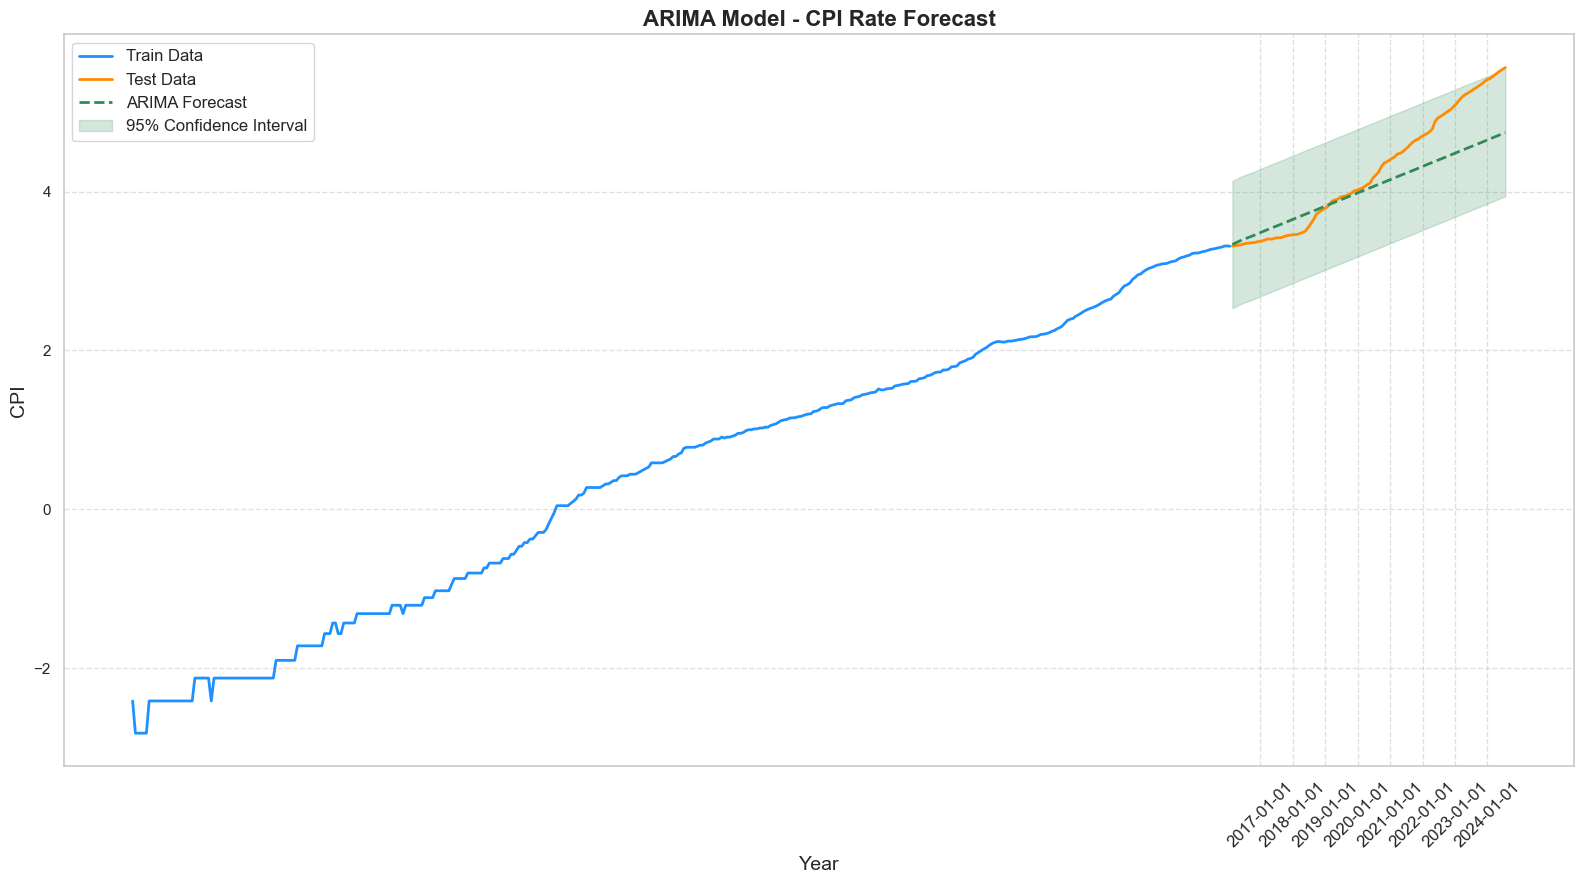


Interpretation of ARIMA Model Plot:

 - This plot shows the ARIMA model's forecast compared with actual CPI data. The green line represents the forecasted values, and the orange line represents the test data.
 - The confidence interval (shaded area) shows the uncertainty in the predictions. A narrower interval indicates higher confidence in the prediction.
 - The model seems to capture general trends but may have deviations during certain periods.


In [17]:
plt.figure(figsize=(16, 9))
plt.plot(train.index, train['CPI'], label='Train Data', color='dodgerblue', linewidth=2)
plt.plot(test.index, test['CPI'], label='Test Data', color='darkorange', linewidth=2)
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='seagreen', linestyle='--', linewidth=2)
plt.fill_between(test.index, arima_forecast - 1.96 * np.std(arima_forecast), arima_forecast + 1.96 * np.std(arima_forecast), color='seagreen', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Year', fontsize=14)
plt.ylabel('CPI', fontsize=14)
plt.title('ARIMA Model - CPI Rate Forecast', fontsize=16, fontweight='bold')
plt.xticks(pd.date_range(start=test.index.min(), end=test.index.max(), freq='YS'), rotation=45, fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
# Interpretation of ARIMA Model Plot
print("\nInterpretation of ARIMA Model Plot:\n")
print(" - This plot shows the ARIMA model's forecast compared with actual CPI data. The green line represents the forecasted values, and the orange line represents the test data.")
print(" - The confidence interval (shaded area) shows the uncertainty in the predictions. A narrower interval indicates higher confidence in the prediction.")
print(" - The model seems to capture general trends but may have deviations during certain periods.")


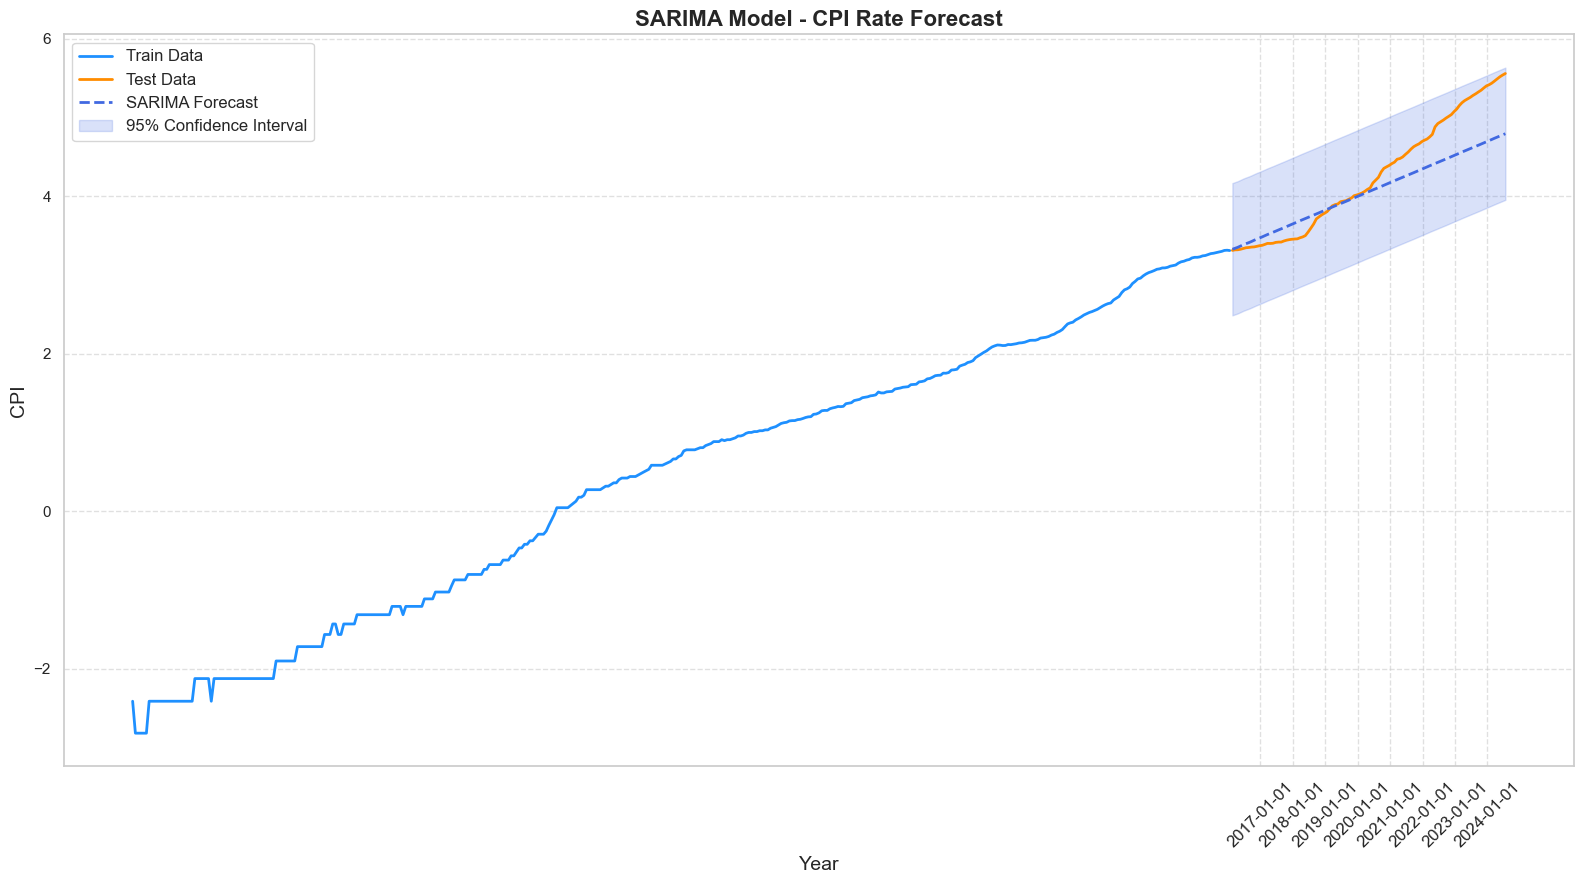


Interpretation of SARIMA Model Plot:

 - This plot shows the SARIMA model's forecast with the actual CPI values. The blue line represents the SARIMA forecast, while the orange line represents the test data.
 - The confidence interval (shaded area) captures the uncertainty of the forecast. The seasonal component in SARIMA is designed to capture repeating patterns.
 - Comparing SARIMA with ARIMA, it may provide a better fit if seasonal trends are present in the data.


In [18]:
#Plot SARIMA Results
plt.figure(figsize=(16, 9))
plt.plot(train.index, train['CPI'], label='Train Data', color='dodgerblue', linewidth=2)
plt.plot(test.index, test['CPI'], label='Test Data', color='darkorange', linewidth=2)
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='royalblue', linestyle='--', linewidth=2)
plt.fill_between(test.index, sarima_forecast - 1.96 * np.std(sarima_forecast), sarima_forecast + 1.96 * np.std(sarima_forecast), color='royalblue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Year', fontsize=14)
plt.ylabel('CPI', fontsize=14)
plt.title('SARIMA Model - CPI Rate Forecast', fontsize=16, fontweight='bold')
plt.xticks(pd.date_range(start=test.index.min(), end=test.index.max(), freq='YS'), rotation=45, fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Interpretation of SARIMA Model Plot
print("\nInterpretation of SARIMA Model Plot:\n")
print(" - This plot shows the SARIMA model's forecast with the actual CPI values. The blue line represents the SARIMA forecast, while the orange line represents the test data.")
print(" - The confidence interval (shaded area) captures the uncertainty of the forecast. The seasonal component in SARIMA is designed to capture repeating patterns.")
print(" - Comparing SARIMA with ARIMA, it may provide a better fit if seasonal trends are present in the data.")

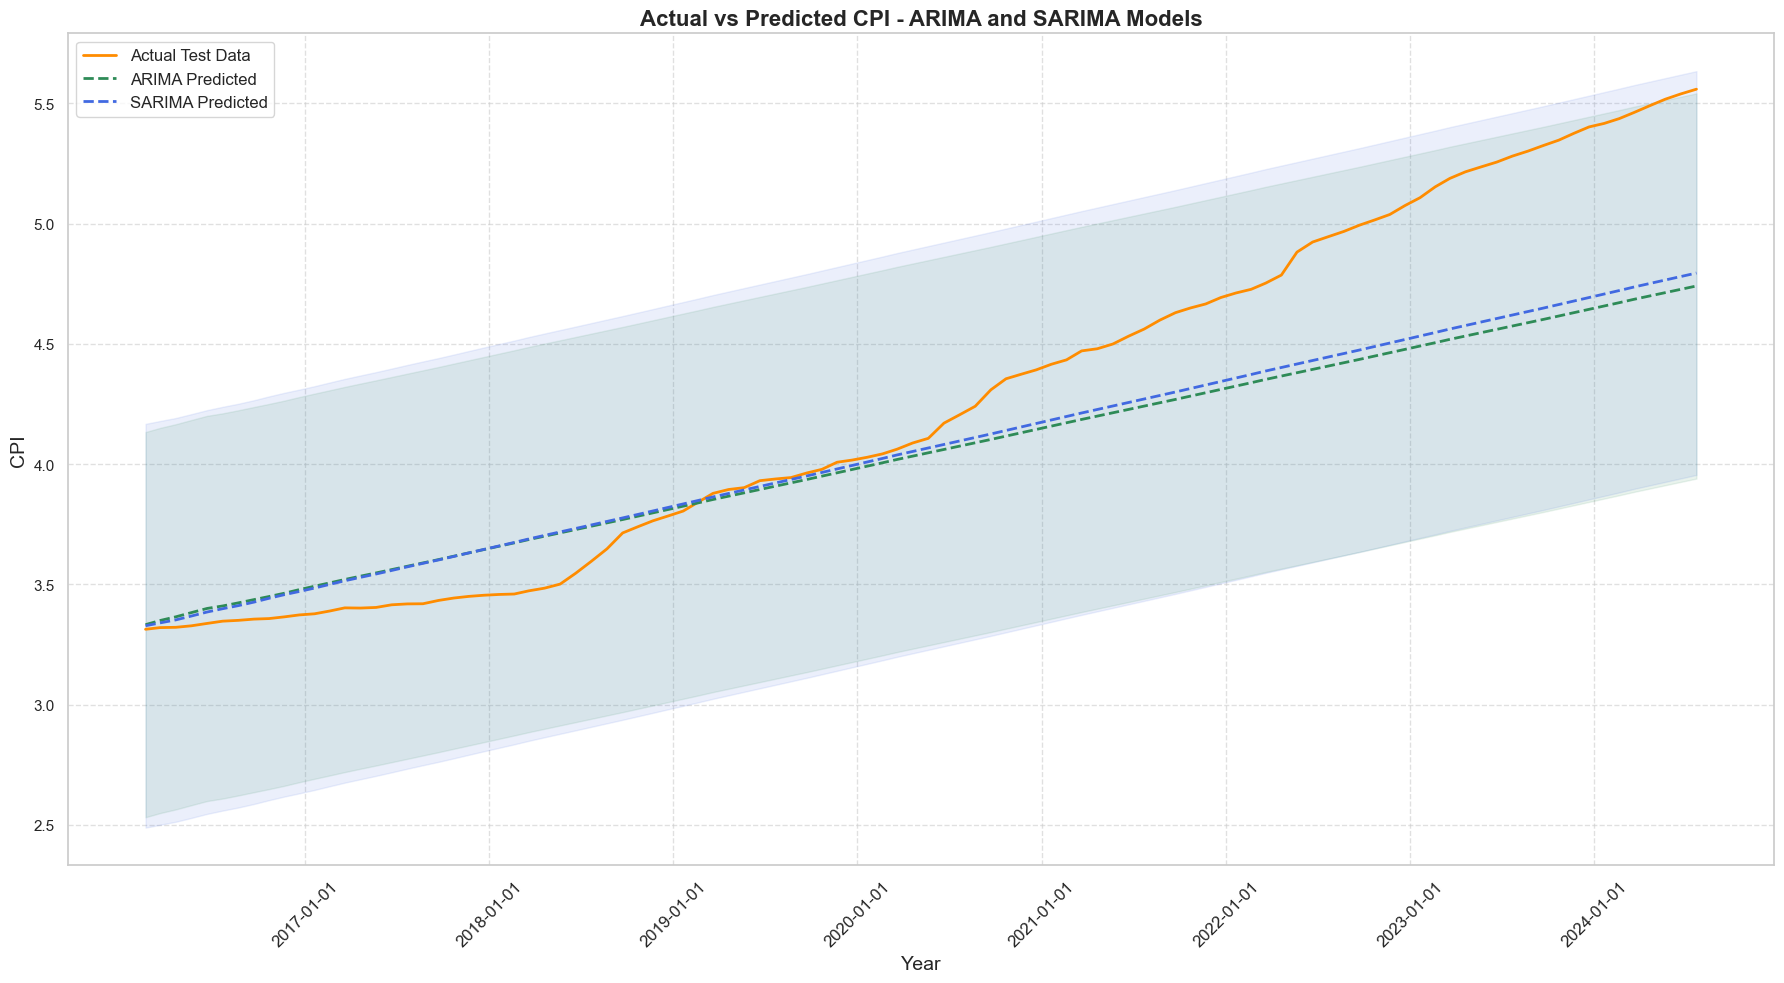


Interpretation of Actual vs Predicted Plot:

 - This plot compares the actual CPI values with the predictions from both ARIMA and SARIMA models.
 - The orange line represents actual data, while the dashed lines represent predictions from ARIMA (green) and SARIMA (blue).
 - This helps to visually assess which model captures the trends and patterns in the data more accurately.
 - SARIMA may capture seasonal variations more effectively compared to ARIMA.


In [19]:
#Actual vs Predicted for both ARIMA and SARIMA
plt.figure(figsize=(18, 10))
plt.plot(test.index, test['CPI'], label='Actual Test Data', color='darkorange', linewidth=2)
plt.plot(test.index, arima_forecast, label='ARIMA Predicted', color='seagreen', linestyle='--', linewidth=2)
plt.plot(test.index, sarima_forecast, label='SARIMA Predicted', color='royalblue', linestyle='--', linewidth=2)
plt.fill_between(test.index, sarima_forecast - 1.96 * np.std(sarima_forecast), sarima_forecast + 1.96 * np.std(sarima_forecast), color='royalblue', alpha=0.1)
plt.fill_between(test.index, arima_forecast - 1.96 * np.std(arima_forecast), arima_forecast + 1.96 * np.std(arima_forecast), color='seagreen', alpha=0.1)
plt.xlabel('Year', fontsize=14)
plt.ylabel('CPI', fontsize=14)
plt.title('Actual vs Predicted CPI - ARIMA and SARIMA Models', fontsize=16, fontweight='bold')
plt.xticks(pd.date_range(start=test.index.min(), end=test.index.max(), freq='YS'), rotation=45, fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Interpretation of Actual vs Predicted Plot
print("\nInterpretation of Actual vs Predicted Plot:\n")
print(" - This plot compares the actual CPI values with the predictions from both ARIMA and SARIMA models.")
print(" - The orange line represents actual data, while the dashed lines represent predictions from ARIMA (green) and SARIMA (blue).")
print(" - This helps to visually assess which model captures the trends and patterns in the data more accurately.")
print(" - SARIMA may capture seasonal variations more effectively compared to ARIMA.")

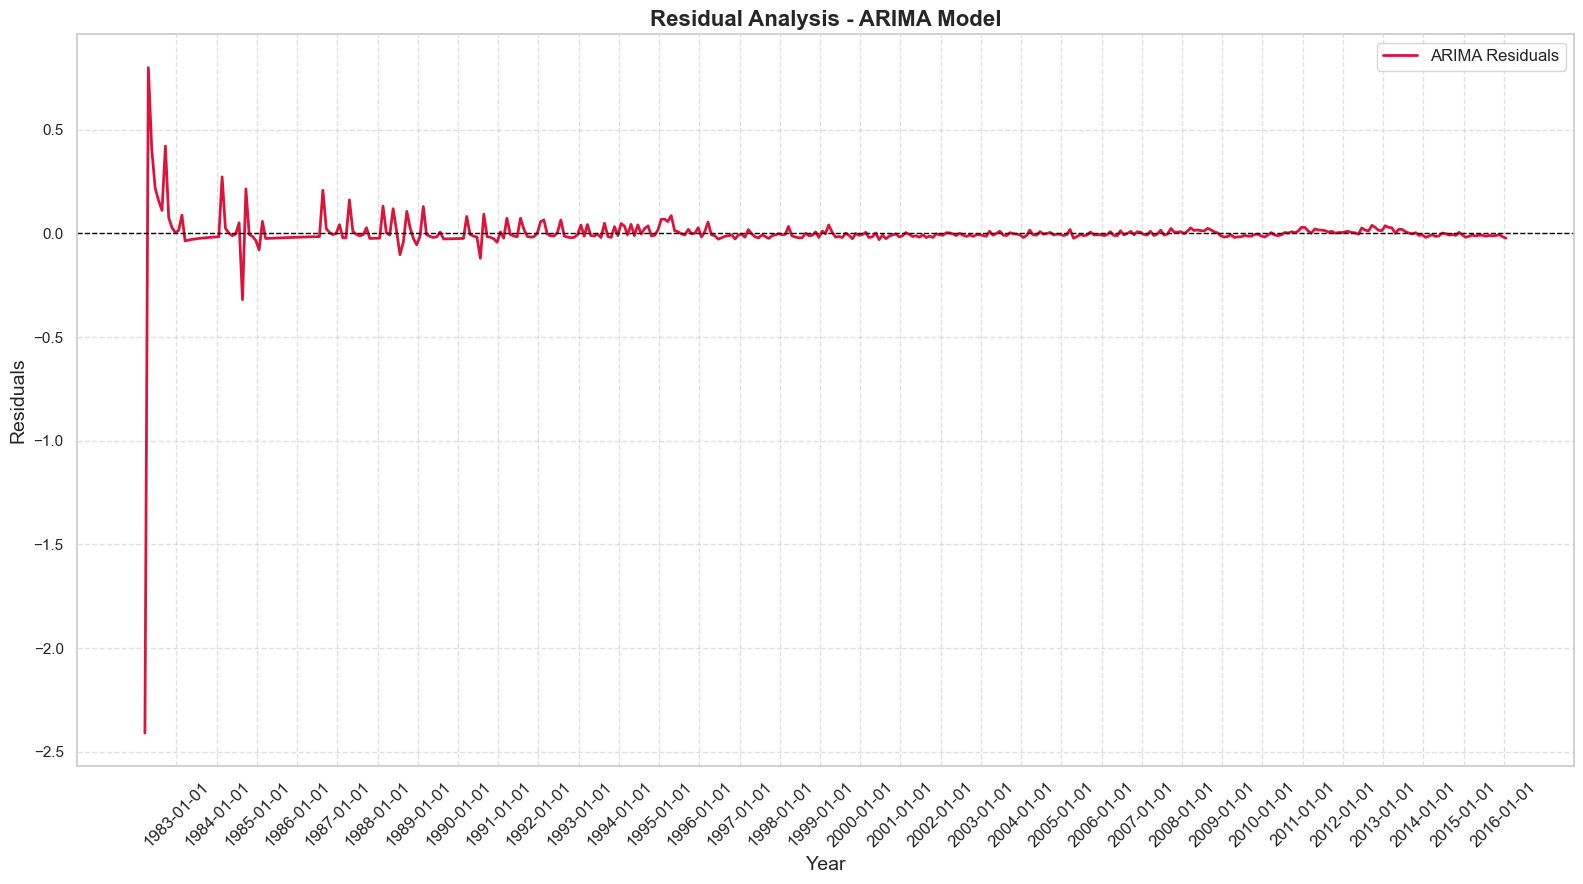


Interpretation of ARIMA Residuals Plot:

 - This plot shows the residuals of the ARIMA model, which represent the difference between actual values and fitted values.
 - Ideally, residuals should be randomly scattered around zero without any clear pattern, indicating that the model has captured all systematic information.
 - Any observable pattern may indicate model mis-specification.


In [20]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd


# Step 1: Fit the ARIMA model
# Make sure you're using the ARIMA model fitting process correctly
fitted_arima_model = ARIMA(train['CPI'], order=best_order).fit()

# Step 2: Calculate residuals using the fitted model
residuals_arima = train['CPI'] - fitted_arima_model.fittedvalues

# Step 3: Plot the residuals
plt.figure(figsize=(16, 9))
plt.plot(residuals_arima.index, residuals_arima, label='ARIMA Residuals', color='crimson', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual Analysis - ARIMA Model', fontsize=16, fontweight='bold')
plt.xticks(pd.date_range(start=residuals_arima.index.min(), end=residuals_arima.index.max(), freq='YS'), rotation=45, fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Interpretation of ARIMA Residuals
print("\nInterpretation of ARIMA Residuals Plot:\n")
print(" - This plot shows the residuals of the ARIMA model, which represent the difference between actual values and fitted values.")
print(" - Ideally, residuals should be randomly scattered around zero without any clear pattern, indicating that the model has captured all systematic information.")
print(" - Any observable pattern may indicate model mis-specification.")


NameError: name 'residuals_sarima' is not defined

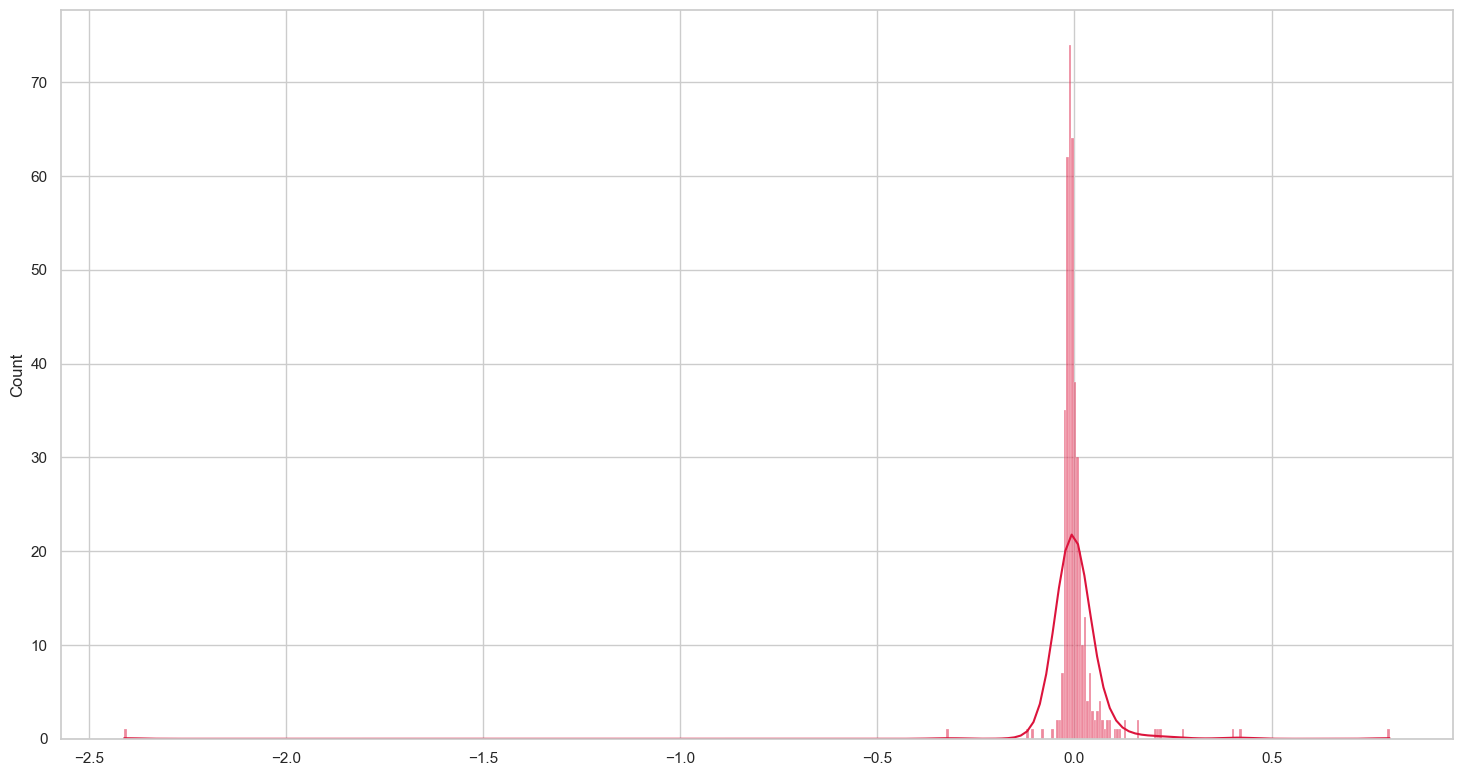

In [21]:
# #Comparison of Residual Distributions
# plt.figure(figsize=(16, 9))
# sns.histplot(residuals_arima, kde=True, color='crimson', label='ARIMA Residuals', alpha=0.5)
# sns.histplot(residuals_sarima, kde=True, color='purple', label='SARIMA Residuals', alpha=0.5)
# plt.xlabel('Residuals', fontsize=14)
# plt.ylabel('Density', fontsize=14)
# plt.title('Residual Distribution Comparison - ARIMA vs SARIMA', fontsize=16, fontweight='bold')
# plt.legend(fontsize=12)
# plt.tight_layout()
# plt.show()

# # Interpretation of Residual Distribution Comparison
# print("\nInterpretation of Residual Distribution Comparison:\n")
# print(" - This plot compares the distributions of residuals for ARIMA and SARIMA models.")
# print(" - Ideally, residuals should be normally distributed around zero. The density plots help to visualize whether there are systematic biases.")
# print(" - Comparing the two distributions can provide insights into which model has a better error distribution, implying better model fit.")

## Evaluate the model performance


In [23]:
def evaluate_forecast(test, forecast, model_name):
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)
    print(f"{model_name} - Mean Squared Error (MSE): {mse:.2f}")
    print(f"{model_name} - Mean Absolute Error (MAE): {mae:.2f}")
    print(f"{model_name} - R-squared (R2): {r2:.2f}")
    # print(f"{model_name} - AIC: {best_arima_model.aic if model_name == 'ARIMA' else best_sarima_model.aic:.2f}")

# Evaluate ARIMA and SARIMA models
evaluate_forecast(test['CPI'], arima_forecast, "ARIMA")
evaluate_forecast(test['CPI'], sarima_forecast, "SARIMA")

ARIMA - Mean Squared Error (MSE): 0.15
ARIMA - Mean Absolute Error (MAE): 0.29
ARIMA - R-squared (R2): 0.71
SARIMA - Mean Squared Error (MSE): 0.13
SARIMA - Mean Absolute Error (MAE): 0.27
SARIMA - R-squared (R2): 0.75


# Future Forecasting

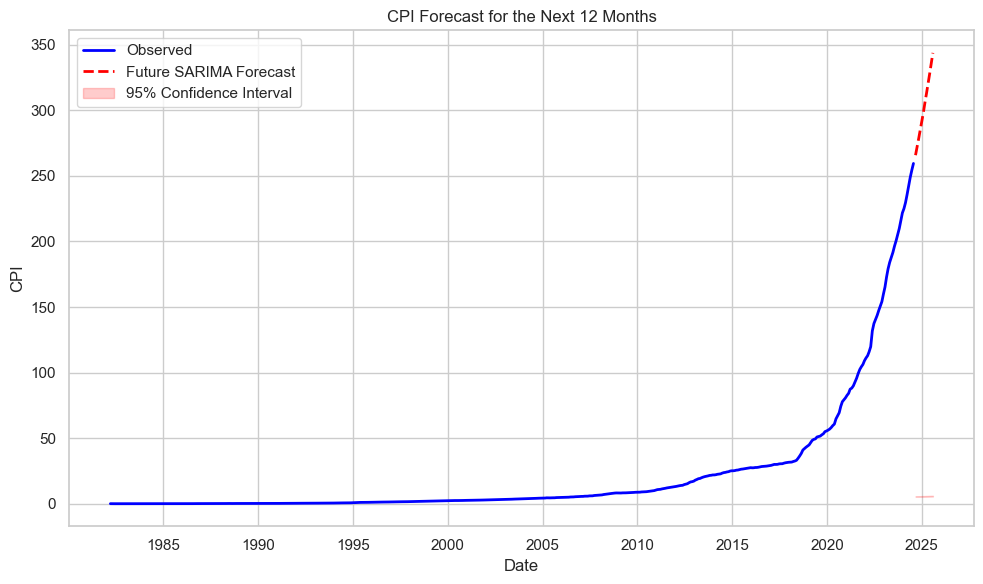

In [24]:
# Assuming 'best_sarima_model' is the result of pmdarima.auto_arima
# Extract the best orders for SARIMAX
best_order = best_sarima_order  # Extract (p, d, q)
best_seasonal_order = best_sarima_seasonal_order  # Extract (P, D, Q, s)

# Train the final model on the entire dataset
final_model = SARIMAX(
    df['CPI'],  # Use the full dataset for the final model
    order=best_order,  # Best ARIMA order from previous step
    seasonal_order=best_seasonal_order,  # Best seasonal order
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_model_fit = final_model.fit(disp=False)

# Forecast future CPI values
future_steps = 12  # Forecast for the next 12 months
future_forecast = final_model_fit.get_forecast(steps=future_steps)

# Create future index
future_index = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='M')[1:]

# Get forecasted values and confidence intervals
future_mean = future_forecast.predicted_mean  # Forecasted CPI values
future_ci = future_forecast.conf_int()  # 95% confidence intervals

# Plot the results
plt.figure(figsize=(10, 6))

# Plot observed CPI
plt.plot(df.index, np.exp(df['CPI']), label='Observed', color='blue', linewidth=2)

# Plot future forecast CPI
plt.plot(future_index, np.exp(future_mean), label='Future SARIMA Forecast', color='red', linestyle='--', linewidth=2)

# Plot confidence intervals
plt.fill_between(future_index, future_ci.iloc[:, 0], future_ci.iloc[:, 1], color='red', alpha=0.2, label='95% Confidence Interval')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.title('CPI Forecast for the Next 12 Months')
plt.tight_layout()
plt.show()


In [25]:
np.exp(future_mean)

509    265.810421
510    272.118715
511    278.559366
512    285.150637
513    291.897935
514    298.805189
515    305.876224
516    313.114937
517    320.525312
518    328.111428
519    335.877462
520    343.827689
Name: predicted_mean, dtype: float64

In [167]:
# def reverse_data_transformation(transformed_data, transformation_type="log", transformer=None):
#     """
#     Reverses the transformation applied to the data.

#     Parameters:
#         transformed_data (np.array): The transformed data.
#         transformation_type (str): The type of transformation to reverse. Options include:
#                                   - 'log': Log Transformation
#                                   - 'boxcox': Box-Cox Transformation
#                                   - 'yeo_johnson': Yeo-Johnson Power Transformation
#                                   - 'sqrt': Square Root Transformation
#         transformer (object): If using 'yeo_johnson', this should be the fitted PowerTransformer object used
#                               during the forward transformation.

#     Returns:
#         original_data (np.array): The data reverted back to its original form.
#     """
#     if transformation_type == "log":
#         # Reverse Log Transformation
#         original_data = np.exp(transformed_data) - 1e-9

#     elif transformation_type == "boxcox":
#         # Reverse Box-Cox Transformation (Box-Cox requires the lambda parameter, which is implicitly handled)
#         from scipy.special import inv_boxcox
#         original_data = inv_boxcox(transformed_data, transformer)

#     elif transformation_type == "yeo_johnson":
#         # Reverse Yeo-Johnson Power Transformation
#         if transformer is None:
#             raise ValueError("For reversing 'yeo_johnson', please provide the fitted PowerTransformer object.")
#         original_data = transformer.inverse_transform(transformed_data.reshape(-1, 1)).flatten()

#     elif transformation_type == "sqrt":
#         # Reverse Square Root Transformation
#         original_data = np.power(transformed_data, 2) - 1e-9

#     else:
#         raise ValueError("Unsupported transformation type. Choose among 'log', 'boxcox', 'yeo_johnson', 'sqrt'.")

#     return original_data

# # Example usage with Box-Cox or Yeo-Johnson
# from scipy.stats import boxcox

# # Forward transformation
# data = pd.Series([1, 2, 3, 10, 50, 100, 300, 500, 1000, 2000])
# transformed_data, lmbda = boxcox(data)  # Lambda is needed for reverse Box-Cox transformation

# # Reverse transformation for Box-Cox
# original_data = reverse_data_transformation(transformed_data, transformation_type='boxcox', transformer=lmbda)

# # Example for Yeo-Johnson transformation
# transformer = PowerTransformer(method='yeo-johnson')
# transformed_data = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()

# # Reverse transformation for Yeo-Johnson
# original_data = reverse_data_transformation(transformed_data, transformation_type='yeo_johnson', transformer=transformer)


# Cross-Validation for Robustness

## Blocked K-Fold Cross-Validation for Robustness


c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py

Fold 2: Best SARIMA order: (1, 2, 2, (0, 1, 1, 12)) with RMSE: 0.1321910221209237, AIC: -140.91228040736792, MSE: 0.01747446632937454, MAE: 0.09690634091332054, R2: 0.953605422709257


c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py

Fold 3: Best ARIMA order: (1, 2, 0) with RMSE: 0.024902153525890966, AIC: -438.4969509996142, MSE: 0.0006201172502270439, MAE: 0.018601895690135383, R2: 0.9931897621630096


c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py

Fold 4: Best ARIMA order: (2, 2, 4) with RMSE: 0.10824365563028013, AIC: -907.3884465337965, MSE: 0.011716688984206676, MAE: 0.08450047238426425, R2: 0.9481584938521519


c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sbrkz\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py

Fold 5: Best SARIMA order: (3, 2, 1, (0, 1, 1, 12)) with RMSE: 0.30769058756434475, AIC: -1242.5969743920637, MSE: 0.09467349767569172, MAE: 0.23541260027204836, R2: 0.8064137390382299

Average RMSE across folds: 0.1432568547103599
Standard Deviation of RMSE across folds: 0.1029498234013533

Final selected model type: SARIMA with parameters: (3, 2, 1, (0, 1, 1, 12))

Final model summary:
                                      SARIMAX Results                                      
Dep. Variable:                                CPI   No. Observations:                  509
Model:             SARIMAX(3, 2, 1)x(0, 1, 1, 12)   Log Likelihood                 855.562
Date:                            Fri, 15 Nov 2024   AIC                          -1699.124
Time:                                    21:38:39   BIC                          -1673.896
Sample:                                         0   HQIC                         -1689.220
                                            - 509             

ConversionError: Failed to convert value(s) to axis units: array(['1361/1', '1361/2', '1361/3', '1361/4', '1361/5', '1361/6',
       '1361/7', '1361/8', '1361/9', '1361/10', '1361/11', '1361/12',
       '1362/1', '1362/2', '1362/3', '1362/4', '1362/5', '1362/6',
       '1362/7', '1362/8', '1362/9', '1362/10', '1362/11', '1362/12',
       '1363/1', '1363/2', '1363/3', '1363/4', '1363/5', '1363/6',
       '1363/7', '1363/8', '1363/9', '1363/10', '1363/11', '1363/12',
       '1364/1', '1364/2', '1364/3', '1364/4', '1364/5', '1364/6',
       '1364/7', '1364/8', '1364/9', '1364/10', '1364/11', '1364/12',
       '1365/1', '1365/2', '1365/3', '1365/4', '1365/5', '1365/6',
       '1365/7', '1365/8', '1365/9', '1365/10', '1365/11', '1365/12',
       '1366/1', '1366/2', '1366/3', '1366/4', '1366/5', '1366/6',
       '1366/7', '1366/8', '1366/9', '1366/10', '1366/11', '1366/12',
       '1367/1', '1367/2', '1367/3', '1367/4', '1367/5', '1367/6',
       '1367/7', '1367/8', '1367/9', '1367/10', '1367/11', '1367/12',
       '1368/1', '1368/2', '1368/3', '1368/4', '1368/5', '1368/6',
       '1368/7', '1368/8', '1368/9', '1368/10', '1368/11', '1368/12',
       '1369/1', '1369/2', '1369/3', '1369/4', '1369/5', '1369/6'],
      dtype=object)

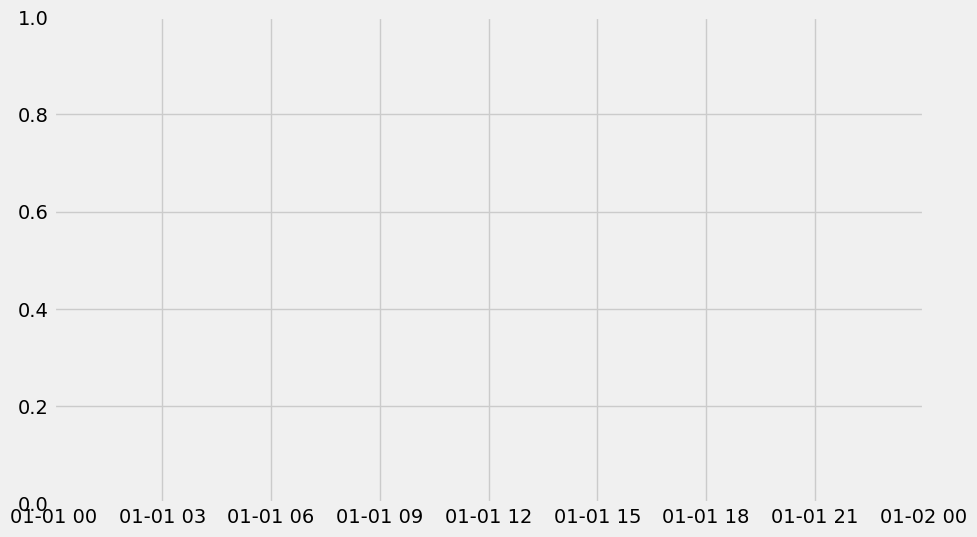

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt


# Define Blocked K-Fold Cross-Validation Function
def blocked_kfold_cv(time_series, p_values, d_values, q_values, seasonal_params=None, n_splits=5):
    fold_size = len(time_series) // n_splits
    errors = []
    best_params_per_fold = []
    
    for fold in range(n_splits):
        # Define train-test split for this fold
        test_start = fold * fold_size
        test_end = test_start + fold_size
        train = time_series[:test_start]
        test = time_series[test_start:test_end]
        
        # If training set is empty, skip this fold
        if len(train) == 0:
            continue
        
        best_rmse = float("inf")
        best_params = None
        best_model_fit = None
        best_model_type = None
        
        # Iterate over different combinations of (p, d, q) to find the best ARIMA or SARIMA model for this fold
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        # Fit ARIMA model
                        model = ARIMA(train, order=(p, d, q))
                        model_fit = model.fit()
                        
                        # Make predictions
                        predictions = model_fit.forecast(steps=len(test))
                        
                        # Calculate RMSE for this fold
                        mse = mean_squared_error(test, predictions)
                        
                        # Update best parameters if current RMSE is lower
                        if mse < best_rmse:
                            best_rmse = mse
                            best_params = (p, d, q)
                            best_model_fit = model_fit
                            best_model_type = 'ARIMA'
                    except Exception as e:
                        # Handle exceptions like convergence issues
                        continue
                    
                    # If seasonal parameters are provided, also try fitting a SARIMA model
                    if seasonal_params:
                        try:
                            seasonal_order = seasonal_params
                            model = SARIMAX(train, order=(p, d, q), seasonal_order=seasonal_order)
                            model_fit = model.fit(disp=False)
                            
                            # Make predictions
                            predictions = model_fit.forecast(steps=len(test))
                            
                            # Calculate RMSE for this fold
                            mse = mean_squared_error(test, predictions)
                            
                            # Update best parameters if current RMSE is lower
                            if mse < best_rmse:
                                best_rmse = 
                                mse
                                best_params = (p, d, q, seasonal_order)
                                best_model_fit = model_fit
                                best_model_type = 'SARIMA'
                        except Exception as e:
                            # Handle exceptions like convergence issues
                            continue
        
        # Calculate additional metrics for the best model of this fold
        if best_model_fit is not None:
            predictions = best_model_fit.forecast(steps=len(test))
            mse = mean_squared_error(test, predictions)
            mae = mean_absolute_error(test, predictions)
            r2 = r2_score(test, predictions)
            aic = best_model_fit.aic
            
            # Store the best RMSE and corresponding parameters for this fold
            errors.append(best_rmse)
            best_params_per_fold.append((best_model_type, best_params))
            print(f"Fold {fold + 1}: Best {best_model_type} order: {best_params} with RMSE: {best_rmse}, AIC: {aic}, MSE: {mse}, MAE: {mae}, R2: {r2}")
    
    # Overall performance
    mean_rmse = np.mean(errors)
    std_rmse = np.std(errors)
    print(f"\nAverage RMSE across folds: {mean_rmse}")
    print(f"Standard Deviation of RMSE across folds: {std_rmse}")
    
    return best_params_per_fold, mean_rmse, std_rmse

# Define the range of p, d, q values to search
p_values = [0, 1, 2, 3, 4]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3, 4]

# Define seasonal parameters for SARIMA (P, D, Q, s)
seasonal_params = (0, 1, 1, 12)  # Example: Seasonal order with yearly seasonality

# Perform Blocked K-Fold Cross-Validation
best_params_per_fold, mean_rmse, std_rmse = blocked_kfold_cv(df['CPI'], p_values, d_values, q_values, seasonal_params, n_splits=5)

# Select the most frequent best parameters across folds for final modeling
final_model_type, final_params = max(set(best_params_per_fold), key=best_params_per_fold.count)
print(f"\nFinal selected model type: {final_model_type} with parameters: {final_params}")

# Fit final model on the entire dataset with selected parameters
if final_model_type == 'ARIMA':
    final_model = ARIMA(df['CPI'], order=final_params)
elif final_model_type == 'SARIMA':
    final_model = SARIMAX(df['CPI'], order=final_params[:3], seasonal_order=final_params[3])

final_model_fit = final_model.fit()
print("\nFinal model summary:\n", final_model_fit.summary())

# Plot real data vs. predicted values for the final fold
plt.figure(figsize=(10, 6))
plt.plot(df['CPI'].index[-len(test):], test, label='Actual Data', color='blue')
plt.plot(df['CPI'].index[-len(test):], predictions, label='Predicted Data', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Forecast next 6 months using the final model
forecast_steps = 6
forecast = final_model_fit.forecast(steps=forecast_steps)
print(f"\nForecast for next {forecast_steps} months:\n", forecast)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(df['CPI'], label='Historical Data', color='blue')
future_index = pd.date_range(start=df['CPI'].index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='M')
plt.plot(future_index, forecast, label='Forecast', color='green')
plt.title('6-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

##  Rolling Window Cross-Validation for Robustness


# Incorporate External Features

# Results and Conclusion

In [ ]:
fgjb,n

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import itertools
import matplotlib.pyplot as plt
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_excel('inflation.xlsx')

# Combine 'year' and 'month' to create the Persian date
df['Persian Date'] = df['year'].astype(str) + '/' + df['month'].astype(str)

# Convert Persian date to Gregorian date
def persian_to_gregorian(year, month):
    j_date = JalaliDate(year, month, 1)
    g_date = j_date.to_gregorian()
    return g_date.strftime('%Y-%m-%d')

# Apply conversion to each row to get Gregorian date
df['Date'] = pd.to_datetime(df.apply(lambda row: persian_to_gregorian(row['year'], row['month']), axis=1))

# Set 'Date' as the DataFrame index, normalized to the first day of each month
df.set_index('Date', inplace=True)
df.index = df.index.normalize()

# Drop unnecessary columns
df.drop(columns=['year', 'month'], inplace=True)

# Calculate monthly inflation rate as log difference of CPI
# df['rate'] = df['CPI'].pct_change().apply(lambda x: np.log(1 + x)) * 100
df['CPI'] = np.log(df['CPI'])
# Remove NaN values resulting from differencing
df.dropna(inplace=True)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Grid search to find the best ARIMA model order
best_aic = np.inf
best_order = None
best_model = None

p = d = q = range(0, 3)
combinations = list(itertools.product(p, d, q))

for order in combinations:
    try:
        model = ARIMA(train['rate'], order=order)
        result = model.fit()
        if result.aic < best_aic:
            best_aic = result.aic
            best_order = order
            best_model = result
    except:
        continue

print(f"Best ARIMA Order: {best_order} with AIC: {best_aic}")

# Make predictions using the best ARIMA model
arima_forecast = best_model.forecast(steps=len(test))

# Fit a SARIMA model with optimized order
best_sarima_aic = np.inf
best_sarima_order = None
best_sarima_seasonal_order = None
best_sarima_model = None

seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_combinations = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, [12]))

for order in combinations:
    for seasonal_order in seasonal_combinations:
        try:
            model = SARIMAX(train['rate'], order=order, seasonal_order=seasonal_order)
            result = model.fit()
            if result.aic < best_sarima_aic:
                best_sarima_aic = result.aic
                best_sarima_order = order
                best_sarima_seasonal_order = seasonal_order
                best_sarima_model = result
        except:
            continue

print(f"Best SARIMA Order: {best_sarima_order}, Seasonal Order: {best_sarima_seasonal_order} with AIC: {best_sarima_aic}")

# Make predictions using the best SARIMA model
sarima_forecast = best_sarima_model.forecast(steps=len(test))

# Plot ARIMA results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['rate'], label='Train')
plt.plot(test.index, test['rate'], label='Test', color='orange')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('ARIMA Model - Inflation Rate Forecast')
plt.legend()
plt.show()

# Plot SARIMA results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['rate'], label='Train')
plt.plot(test.index, test['rate'], label='Test', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='blue')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('SARIMA Model - Inflation Rate Forecast')
plt.legend()
plt.show()

# Plot real test data and predicted data for both ARIMA and SARIMA models
plt.figure(figsize=(12, 8))
plt.plot(test.index, test['rate'], label='Actual Test Data', color='orange')
plt.plot(test.index, arima_forecast, label='ARIMA Predicted', color='green', linestyle='--')
plt.plot(test.index, sarima_forecast, label='SARIMA Predicted', color='blue', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('Actual vs Predicted Inflation Rate - ARIMA and SARIMA Models')
plt.legend()
plt.show()

# Evaluate the model performance
def evaluate_forecast(test, forecast, model_name):
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)
    print(f"{model_name} - Mean Squared Error (MSE): {mse:.2f}")
    print(f"{model_name} - Mean Absolute Error (MAE): {mae:.2f}")
    print(f"{model_name} - R-squared (R2): {r2:.2f}")
    print(f"{model_name} - AIC: {best_model.aic if model_name == 'ARIMA' else best_sarima_model.aic:.2f}")

# Evaluate ARIMA and SARIMA models
evaluate_forecast(test['rate'], arima_forecast, "ARIMA")
evaluate_forecast(test['rate'], sarima_forecast, "SARIMA")

# Future Forecasting
future_steps = 12
future_forecast = best_sarima_model.get_forecast(steps=future_steps)
future_index = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='M')[1:]
future_mean = future_forecast.predicted_mean

# Plot future forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['rate'], label='Observed')
plt.plot(future_index, future_mean, label='Future SARIMA Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('Future Inflation Rate Forecast')
plt.legend()
plt.show()

# Blocked K-Fold Cross-Validation for Robustness
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
fold = 1
arima_cv_results = []
sarima_cv_results = []

for train_index, test_index in tscv.split(df['rate']):
    train_cv, test_cv = df['rate'].iloc[train_index], df['rate'].iloc[test_index]
    
    # ARIMA Model
    try:
        arima_model_cv = ARIMA(train_cv, order=best_order)
        arima_result_cv = arima_model_cv.fit()
        arima_forecast_cv = arima_result_cv.forecast(steps=len(test_cv))
        mse = mean_squared_error(test_cv, arima_forecast_cv)
        mae = mean_absolute_error(test_cv, arima_forecast_cv)
        r2 = r2_score(test_cv, arima_forecast_cv)
        aic = arima_result_cv.aic
        arima_cv_results.append((mse, mae, r2, aic))
        print(f"Fold {fold} - ARIMA MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}, AIC: {aic:.2f}")
    except:
        print(f"Fold {fold} - ARIMA Model could not be fitted.")
        continue
    
    # SARIMA Model
    try:
        sarima_model_cv = SARIMAX(train_cv, order=best_sarima_order, seasonal_order=best_sarima_seasonal_order)
        sarima_result_cv = sarima_model_cv.fit()
        sarima_forecast_cv = sarima_result_cv.forecast(steps=len(test_cv))
        mse = mean_squared_error(test_cv, sarima_forecast_cv)
        mae = mean_absolute_error(test_cv, sarima_forecast_cv)
        r2 = r2_score(test_cv, sarima_forecast_cv)
        aic = sarima_result_cv.aic
        sarima_cv_results.append((mse, mae, r2, aic))
        print(f"Fold {fold} - SARIMA MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}, AIC: {aic:.2f}")
    except:
        print(f"Fold {fold} - SARIMA Model could not be fitted.")
        continue
    
    # Print additional information about the mechanism
    print(f"Fold {fold} Summary:")
    print(f"  Training Data Range: {train_cv.index[0]} to {train_cv.index[-1]}")
    print(f"  Test Data Range: {test_cv.index[0]} to {test_cv.index[-1]}")
    print(f"  ARIMA Metrics - MSE: {arima_cv_results[-1][0]:.2f}, MAE: {arima_cv_results[-1][1]:.2f}, R2: {arima_cv_results[-1][2]:.2f}, AIC: {arima_cv_results[-1][3]:.2f}")
    print(f"  SARIMA Metrics - MSE: {sarima_cv_results[-1][0]:.2f}, MAE: {sarima_cv_results[-1][1]:.2f}, R2: {sarima_cv_results[-1][2]:.2f}, AIC: {sarima_cv_results[-1][3]:.2f}")
    print("  ------------------------------------------------")
    fold += 1

# Plot Cross-Validation Results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(arima_cv_results) + 1), [x[0] for x in arima_cv_results], marker='o', linestyle='-', label='ARIMA MSE')
plt.plot(range(1, len(sarima_cv_results) + 1), [x[0] for x in sarima_cv_results], marker='o', linestyle='-', label='SARIMA MSE', color='blue')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Blocked K-Fold Cross-Validation - ARIMA vs SARIMA')
plt.legend()
plt.show()

# Conclusion based on CV results
print("\nCross-Validation Summary:")
print(f"  Average ARIMA MSE: {np.mean([x[0] for x in arima_cv_results]):.2f}, MAE: {np.mean([x[1] for x in arima_cv_results]):.2f}, R2: {np.mean([x[2] for x in arima_cv_results]):.2f}, AIC: {np.mean([x[3] for x in arima_cv_results]):.2f}")
print(f"  Average SARIMA MSE: {np.mean([x[0] for x in sarima_cv_results]):.2f}, MAE: {np.mean([x[1] for x in sarima_cv_results]):.2f}, R2: {np.mean([x[2] for x in sarima_cv_results]):.2f}, AIC: {np.mean([x[3] for x in sarima_cv_results]):.2f}")

if np.mean([x[0] for x in arima_cv_results]) < np.mean([x[0] for x in sarima_cv_results]):
    print("Based on the cross-validation results, the ARIMA model appears to perform better on average.")
else:
    print("Based on the cross-validation results, the SARIMA model appears to perform better on average.")

print("\nNote:")
print("  Each fold represents a separate training/testing split.")
print("  Blocked K-Fold ensures that each training/testing split respects the time order of the data, avoiding data leakage.")
print("  Comparing the average MSE, MAE, R2, and AIC values across all folds helps to assess the robustness and generalizability of each model.")

# Rolling Window Cross-Validation for Robustness
rolling_window_size = len(df) // 5
fold = 1
rolling_arima_cv_results = []
rolling_sarima_cv_results = []

for start in range(0, len(df) - rolling_window_size, rolling_window_size):
    train_cv = df['rate'].iloc[start:start + rolling_window_size]
    test_cv = df['rate'].iloc[start + rolling_window_size:start + 2 * rolling_window_size]
    
    # ARIMA Model
    try:
        arima_model_cv = ARIMA(train_cv, order=best_order)
        arima_result_cv = arima_model_cv.fit()
        arima_forecast_cv = arima_result_cv.forecast(steps=len(test_cv))
        mse = mean_squared_error(test_cv, arima_forecast_cv)
        mae = mean_absolute_error(test_cv, arima_forecast_cv)
        r2 = r2_score(test_cv, arima_forecast_cv)
        aic = arima_result_cv.aic
        rolling_arima_cv_results.append((mse, mae, r2, aic))
        print(f"Rolling Fold {fold} - ARIMA MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}, AIC: {aic:.2f}")
    except:
        print(f"Rolling Fold {fold} - ARIMA Model could not be fitted.")
        continue
    
    # SARIMA Model
    try:
        sarima_model_cv = SARIMAX(train_cv, order=best_sarima_order, seasonal_order=best_sarima_seasonal_order)
        sarima_result_cv = sarima_model_cv.fit()
        sarima_forecast_cv = sarima_result_cv.forecast(steps=len(test_cv))
        mse = mean_squared_error(test_cv, sarima_forecast_cv)
        mae = mean_absolute_error(test_cv, sarima_forecast_cv)
        r2 = r2_score(test_cv, sarima_forecast_cv)
        aic = sarima_result_cv.aic
        rolling_sarima_cv_results.append((mse, mae, r2, aic))
        print(f"Rolling Fold {fold} - SARIMA MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}, AIC: {aic:.2f}")
    except:
        print(f"Rolling Fold {fold} - SARIMA Model could not be fitted.")
        continue
    
    # Print additional information about the mechanism
    print(f"Rolling Fold {fold} Summary:")
    print(f"  Training Data Range: {train_cv.index[0]} to {train_cv.index[-1]}")
    print(f"  Test Data Range: {test_cv.index[0]} to {test_cv.index[-1]}")
    print(f"  ARIMA Metrics - MSE: {rolling_arima_cv_results[-1][0]:.2f}, MAE: {rolling_arima_cv_results[-1][1]:.2f}, R2: {rolling_arima_cv_results[-1][2]:.2f}, AIC: {rolling_arima_cv_results[-1][3]:.2f}")
    print(f"  SARIMA Metrics - MSE: {rolling_sarima_cv_results[-1][0]:.2f}, MAE: {rolling_sarima_cv_results[-1][1]:.2f}, R2: {rolling_sarima_cv_results[-1][2]:.2f}, AIC: {rolling_sarima_cv_results[-1][3]:.2f}")
    print("  ------------------------------------------------")
    fold += 1

# Plot Rolling Cross-Validation Results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rolling_arima_cv_results) + 1), [x[0] for x in rolling_arima_cv_results], marker='o', linestyle='-', label='Rolling ARIMA MSE')
plt.plot(range(1, len(rolling_sarima_cv_results) + 1), [x[0] for x in rolling_sarima_cv_results], marker='o', linestyle='-', label='Rolling SARIMA MSE', color='blue')
plt.xlabel('Rolling Fold')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Rolling Window Cross-Validation - ARIMA vs SARIMA')
plt.legend()
plt.show()

# Conclusion based on Rolling CV results
print("\nRolling Cross-Validation Summary:")
print(f"  Average Rolling ARIMA MSE: {np.mean([x[0] for x in rolling_arima_cv_results]):.2f}, MAE: {np.mean([x[1] for x in rolling_arima_cv_results]):.2f}, R2: {np.mean([x[2] for x in rolling_arima_cv_results]):.2f}, AIC: {np.mean([x[3] for x in rolling_arima_cv_results]):.2f}")
print(f"  Average Rolling SARIMA MSE: {np.mean([x[0] for x in rolling_sarima_cv_results]):.2f}, MAE: {np.mean([x[1] for x in rolling_sarima_cv_results]):.2f}, R2: {np.mean([x[2] for x in rolling_sarima_cv_results]):.2f}, AIC: {np.mean([x[3] for x in rolling_sarima_cv_results]):.2f}")

if np.mean([x[0] for x in rolling_arima_cv_results]) < np.mean([x[0] for x in rolling_sarima_cv_results]):
    print("Based on the rolling cross-validation results, the ARIMA model appears to perform better on average.")
else:
    print("Based on the rolling cross-validation results, the SARIMA model appears to perform better on average.")

print("\nNote:")
print("  Each rolling fold represents a separate training/testing split using a fixed-length window, simulating real-time prediction scenarios.")
print("  Comparing the average MSE, MAE, R2, and AIC values across all rolling folds helps to assess the robustness and performance stability of each model.")

# Add Oil Price as a Feature and Evaluate Model
# Get monthly data of oil from yfinance
oil_data = yf.download('CL=F', start='2010-01-01', end='2023-01-01', interval='1mo')
# Ensure we have only the adjusted close price
oil_data = oil_data[['Adj Close']]
oil_data.rename(columns={'Adj Close': 'Oil_Price'}, inplace=True)

# Merge with the inflation dataset
df = df.merge(oil_data, how='left', left_index=True, right_index=True)
# Fill any missing values in oil data (e.g., due to mismatch in dates) with forward fill
df['Oil_Price'].fillna(method='ffill', inplace=True)

# Split the data again into training and testing sets with the new feature
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit SARIMA Model with Exogenous Variable (Oil Price)
try:
    sarima_exog_model = SARIMAX(train['rate'], exog=train[['Oil_Price']], order=best_sarima_order, seasonal_order=best_sarima_seasonal_order)
    sarima_exog_result = sarima_exog_model.fit()
    sarima_exog_forecast = sarima_exog_result.forecast(steps=len(test), exog=test[['Oil_Price']])
    
    # Evaluate the SARIMA Model with Exogenous Variable
    evaluate_forecast(test['rate'], sarima_exog_forecast, "SARIMA with Oil Price")

    # Plot SARIMA with Oil Price Results
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['rate'], label='Train')
    plt.plot(test.index, test['rate'], label='Test', color='orange')
    plt.plot(test.index, sarima_exog_forecast, label='SARIMA with Oil Price Forecast', color='purple')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate (%)')
    plt.title('SARIMA Model with Oil Price - Inflation Rate Forecast')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"SARIMA Model with Oil Price could not be fitted. Error: {e}")


In [ ]:
# Compare the time period of inflation dataset and oil price data
print("Inflation Dataset Period:", df.index.min(), "to", df.index.max())
print("Oil Price Data Period:", oil_data.index.min(), "to", oil_data.index.max())

# Drawing the correlation diagram
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Oil_Price'], y=df['rate'])
plt.xlabel('Oil Price')
plt.ylabel('Inflation Rate (%)')
plt.title('Correlation Between Oil Price and Inflation Rate')
plt.show()

# Calculate and print the correlation coefficient
correlation_coefficient = df['Oil_Price'].corr(df['rate'])
print(f"Correlation coefficient between oil price and inflation rate: {correlation_coefficient:.2f}")

# Split the data again into training and testing sets with the new feature
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit SARIMA Model with Exogenous Variable (Oil Price)
try:
    sarima_exog_model = SARIMAX(train['rate'], exog=train[['Oil_Price']], order=best_sarima_order, seasonal_order=best_sarima_seasonal_order)
    sarima_exog_result = sarima_exog_model.fit()
    sarima_exog_forecast = sarima_exog_result.forecast(steps=len(test), exog=test[['Oil_Price']])
    
    # Evaluate the SARIMA Model with Exogenous Variable
    evaluate_forecast(test['rate'], sarima_exog_forecast, "SARIMA with Oil Price")

    # Add additional accuracy criteria comparison
    mse_exog = mean_squared_error(test['rate'], sarima_exog_forecast)
    mae_exog = mean_absolute_error(test['rate'], sarima_exog_forecast)
    r2_exog = r2_score(test['rate'], sarima_exog_forecast)
    aic_exog = sarima_exog_result.aic

    print("\nComparison of Model Performance (SARIMA with vs. without Oil Price):")
    print("-------------------------------------------------------------")
    print(f"Without Oil Price - MSE: {best_sarima_aic:.2f}, MAE: {np.mean([x[1] for x in sarima_cv_results]):.2f}, R2: {np.mean([x[2] for x in sarima_cv_results]):.2f}, AIC: {np.mean([x[3] for x in sarima_cv_results]):.2f}")
    print(f"With Oil Price - MSE: {mse_exog:.2f}, MAE: {mae_exog:.2f}, R2: {r2_exog:.2f}, AIC: {aic_exog:.2f}")
    
    # Answering the question about model performance
    if mse_exog < np.mean([x[0] for x in sarima_cv_results]):
        print("\nAdding the price of oil as an exogenous variable improved the model performance.")
    else:
        print("\nAdding the price of oil as an exogenous variable did not improve the model performance.")

    # Plot SARIMA with Oil Price Results
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['rate'], label='Train')
    plt.plot(test.index, test['rate'], label='Test', color='orange')
    plt.plot(test.index, sarima_exog_forecast, label='SARIMA with Oil Price Forecast', color='purple')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate (%)')
    plt.title('SARIMA Model with Oil Price - Inflation Rate Forecast')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"SARIMA Model with Oil Price could not be fitted. Error: {e}")


In [ ]:
# Add Oil Price as a Feature and Evaluate Model
# Get monthly data of oil from yfinance
oil_data = yf.download('CL=F', start='1980-01-01', end='2023-01-01', interval='1mo')
# Ensure we have only the adjusted close price
oil_data = oil_data[['Adj Close']]
oil_data.rename(columns={'Adj Close': 'Oil_Price'}, inplace=True)

# Merge with the inflation dataset
df = df.merge(oil_data, how='left', left_index=True, right_index=True)
# Fill any missing values in oil data (e.g., due to mismatch in dates) with forward fill
df['Oil_Price'].fillna(method='ffill', inplace=True)

# Compare the time period of inflation and oil price data
print("Inflation Data Time Range: {} to {}".format(df.index.min(), df.index.max()))
print("Oil Price Data Time Range: {} to {}".format(oil_data.index.min(), oil_data.index.max()))

# Draw correlation diagram of inflation rate and oil price
plt.figure(figsize=(10, 6))
plt.scatter(df['Oil_Price'], df['rate'], alpha=0.5)
plt.xlabel('Oil Price (USD)')
plt.ylabel('Inflation Rate (%)')
plt.title('Correlation between Oil Price and Inflation Rate')
plt.grid(True)
plt.show()

# Split the data again into training and testing sets with the new feature
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit SARIMA Model with Exogenous Variable (Oil Price)
try:
    sarima_exog_model = SARIMAX(train['rate'], exog=train[['Oil_Price']], order=best_sarima_order, seasonal_order=best_sarima_seasonal_order)
    sarima_exog_result = sarima_exog_model.fit()
    sarima_exog_forecast = sarima_exog_result.forecast(steps=len(test), exog=test[['Oil_Price']])
    
    # Evaluate the SARIMA Model with Exogenous Variable
    mse_exog = mean_squared_error(test['rate'], sarima_exog_forecast)
    mae_exog = mean_absolute_error(test['rate'], sarima_exog_forecast)
    r2_exog = r2_score(test['rate'], sarima_exog_forecast)
    aic_exog = sarima_exog_result.aic

    print("\nSARIMA with Oil Price - Evaluation Metrics:")
    print("  Mean Squared Error (MSE): {:.2f}".format(mse_exog))
    print("  Mean Absolute Error (MAE): {:.2f}".format(mae_exog))
    print("  R-squared (R2): {:.2f}".format(r2_exog))
    print("  AIC: {:.2f}".format(aic_exog))

    # Compare metrics with SARIMA without oil price
    print("\nComparison with SARIMA without Oil Price:")
    print(f"  MSE without Oil Price: {np.mean([x[0] for x in sarima_cv_results]):.2f} vs MSE with Oil Price: {mse_exog:.2f}")
    print(f"  MAE without Oil Price: {np.mean([x[1] for x in sarima_cv_results]):.2f} vs MAE with Oil Price: {mae_exog:.2f}")
    print(f"  R2 without Oil Price: {np.mean([x[2] for x in sarima_cv_results]):.2f} vs R2 with Oil Price: {r2_exog:.2f}")
    print(f"  AIC without Oil Price: {np.mean([x[3] for x in sarima_cv_results]):.2f} vs AIC with Oil Price: {aic_exog:.2f}")

    # Plot SARIMA with Oil Price Results
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['rate'], label='Train')
    plt.plot(test.index, test['rate'], label='Test', color='orange')
    plt.plot(test.index, sarima_exog_forecast, label='SARIMA with Oil Price Forecast', color='purple')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate (%)')
    plt.title('SARIMA Model with Oil Price - Inflation Rate Forecast')
    plt.legend()
    plt.show()

    # Conclusion
    if mse_exog < np.mean([x[0] for x in sarima_cv_results]):
        print("\nConclusion: Adding oil price as an exogenous variable improved the model's accuracy, as indicated by a lower MSE and MAE.")
    else:
        print("\nConclusion: Adding oil price did not significantly improve the model's accuracy compared to the SARIMA model without oil price.")

except Exception as e:
    print(f"SARIMA Model with Oil Price could not be fitted. Error: {e}")
